# Learning Uncertainty Sets

In [138]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lro
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "tab:olive"]

In [2]:
def pareto_frontier(Xs, Ys, maxX = False, maxY = False):
# Sort the list in either ascending or descending order of X
    myList = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
# Start the Pareto frontier with the first value in the sorted list
    p_front = [myList[0]]    
# Loop through the sorted list
    for pair in myList[1:]:
        if maxY: 
            if pair[1] >= p_front[-1][1]: # Look for higher values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
        else:
            if pair[1] <= p_front[-1][1]: # Look for lower values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
# Turn resulting pairs back into a list of Xs and Ys
    p_frontX = [pair[0] for pair in p_front]
    p_frontY = [pair[1] for pair in p_front]
    return p_frontX, p_frontY

## Formulating the uncertainty set

We now formulate the uncertainty set slightly differently, where data and a loss function is passed as parameters instead of the uncertainty set parameters. The parameters for the uncertainty set, $A$ and $b$, will now be trained through differentiable optimization. 


### Ellipsoidal uncertainty: $\{u \mid \| Au + b \|_p \leq 1 \}$ 

- $p$ : integer, optional  
  * Order of the norm. Default 2.
- data : np.array  
  * An array of uncertainty realizations, where each row is one realization.
- loss : function
  * The loss function used to train the uncertainty set. 


### Mean Robust uncertainty: $\{ u = (v_1,\dots,v_K)  \mid  \sum_{k=1} ^K w_k \| A_k(v_k - \bar{d}_k) \|_p^{\text{power}} \le \rho \}$ 

- $K$: int
  * Number of clusters. Default 1.
- $p$ : integer, optional  
  * Order of the norm. Default 2.
- power: integer, optional
  * Power of the norm. Default 1. 
- data : np.array  
  * An array of uncertainty realizations, where each row is one realization.
- loss : function
  * The loss function used to train the uncertainty set. 


### Box uncertainty: $\{ u \mid\| Au + b \|_\infty \leq 1 \}$ 

- data : np.array  
  * An array of uncertainty realizations, where each row is one realization.
- loss : function
  * The loss function used to train the uncertainty set. 

### Budget uncertainty: 

1. train the box portion only: $\{u \mid \| Au + b \|_\infty \leq 1, \| u \|_1 \leq \rho_2\}$ 
2. train the 1-norm portion only: $\{u \mid \| u \|_\infty \leq \rho_1, \| Au + b \|_1 \leq 1\}$ 
- train_box: boolean, optional
  * If True, train the box portion only. Default True. 
- $\rho_1$ : float, optional
  * Box scaling. Default 1.0.
- $\rho_2$ : float, optional
  * 1-norm scaling. Default 1.0.
- data : np.array  
  * An array of uncertainty realizations, where each row is one realization.
- loss : function
  * The loss function used to train the uncertainty set.
  

### Formulating the loss function

The loss function passed into the uncertainty set must be a function that returns torch tensors with gradient information. The function must take in as inputs all the variables defined in the Robust Problem, as well as the data used to evaluate the loss. There may also be other inputs to the function, depending on the type of loss.  
An example of a violation loss is 
$$
\mathcal{L}(\mathcal{D}, x) = f(x)  + \frac{\lambda }{N}\sum_{i=1}^{N} g(d_i,x)_+,
$$
where $\mathcal{D}$ is the dataset, $\lambda$ is the weight on the violation loss, $N$ is the total number of datapoints in the dataset, and $d_i$ is sample $i$ of the dataset. 

### Training the uncertainty set

To train the uncertainty set, after setting up the robust problem, call `problem.train()`, with optional parameters to control whether to train only $\epsilon$ or both $A$ and $b$, the total number of iterations, the learning rate of the problem, the optimizer to use, and initial values for $A$ and $b$. 

The function will return a pandas DataFrame with information on the iterates, as well as the reformulated problem.


### Example 1: Linear Portfolio


Consider the simple portfolio problem where we want to select a portfolio of stocks that maximizes returns. The Robust Problem is formulated as
$$
\begin{array}{ll}
\text{minimize} & \tau\\
\text{subject to}  & -u^Tx \leq  \tau\\
&\mathbf{1}^Tx = 1, x \geq 0,
\end{array}
$$
where $u$ is the uncertain parameter. 

We train an ellipsoidal uncertainty set with $p = 2$, and consider the violation loss $\tau + \lambda(-u^Tx - \tau)_+$, where $\lambda = 1$ is the scaling for the sum of violations. 

In [3]:
# The violation loss function, in torch tensors
def violation_loss(t_soln, x_soln, data, lmbda=1):
    return t_soln + lmbda * torch.mean(
        torch.maximum(-data @ x_soln - t_soln, torch.tensor(0., requires_grad=True))), t_soln,  torch.mean(
        torch.maximum(-data @ x_soln - t_soln, torch.tensor(0., requires_grad=True)))

# Functions to generate data
def normal_returns_scaled(N, m, scale):
    R = np.vstack([np.random.normal(
        i*0.03*scale, np.sqrt((0.02**2+(i*0.025)**2)), N) for i in range(1, m+1)])
    return (R.transpose())

def data_modes(N, m, scales):
    modes = len(scales)
    d = np.zeros((N+100, m))
    weights = int(np.ceil(N/modes))
    for i in range(modes):
        d[i*weights:(i+1)*weights,
          :] = normal_returns_scaled(weights, m, scales[i])
    return d[0:N, :]

# Generate data
num_stocks = 2
N = 100
data = data_modes(N,num_stocks,[1,2,3])

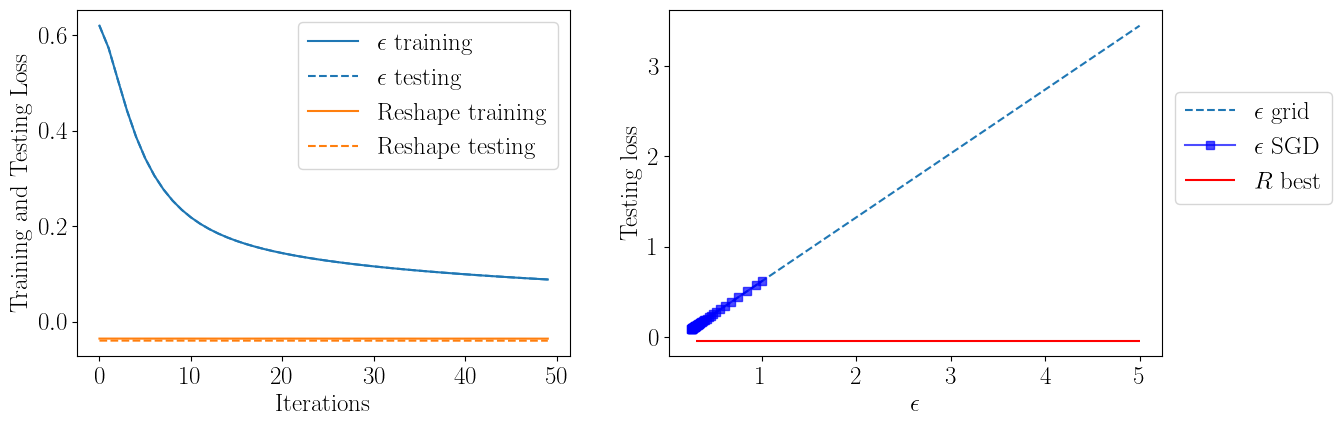

In [4]:

# Formulate the uncertainty set and uncertain parameter
unc_set = lro.Ellipsoidal(data=data, loss=violation_loss)
u = lro.UncertainParameter(num_stocks, uncertainty_set=unc_set)

# Formulate the Robust Problem
x = cp.Variable(num_stocks)
t = cp.Variable()

objective = cp.Minimize(t)
cons = [-u @ x <= t]
cons += [cp.sum(x) == 1, x >= 0]

prob_robust = lro.RobustProblem(objective, cons)
s = 20

# Train only epsilon
result = prob_robust.train(eps=True, lr=0.1, step=50, momentum = 0.8, optimizer = "SGD", initeps = 1, seed = s)
df = result.df


# Train A and b
result1 = prob_robust.train(lr=0.1, step=50, momentum = 0.8, optimizer = "SGD", seed = s)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

# Grid search epsilon
result2 = prob_robust.grid(epslst = np.linspace(0.3, 5, 50), seed = s)
dfgrid = result2.df
# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5))
ax1.plot(df['step'], df['Loss_val'], color="tab:blue", label=r"$\epsilon$ training")
ax1.plot(df['step'], df['Eval_val'], linestyle='--', color="tab:blue", label=r"$\epsilon$ testing")
ax1.plot(df1['step'], df1['Loss_val'], color="tab:orange", label="Reshape training")
ax1.plot(df1['step'], df1['Eval_val'], linestyle='--', color="tab:orange", label="Reshape testing")
ax1.legend()
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Training and Testing Loss")

styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
ax2.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
ax2.plot(df["A_norm"],df["Eval_val"], linestyle='-', marker=styles[j], color = "blue", label="$\epsilon$ SGD",alpha = 0.7)
ax2.hlines( xmin = np.min(dfgrid["Eps"]), xmax = np.max(dfgrid["Eps"]), y = np.min(df1["Eval_val"]), label = "$R$ best", color= "red")   
ax2.set_xlabel("$\epsilon$")
ax2.set_ylabel("Testing loss")
ax2.legend(bbox_to_anchor=(1, 0.8))
plt.show()


### Example 2: Quadratic uncertainty
We consider a problem with quadratic uncertainty, 

$$g(u,x) = \sum_{i=1}^n g_i(u,x), \quad \text{where } \quad g_i(u,x) = -(1/2)u^T(P_ix_i)u.$$ 
We have each $P_i\in \mathbf{R}^{n\times n}$ a symmetric positive definite matrix, $u \in \mathbf{R}^n$ from an ellipsoidal set, and $x \in \mathbf{R}^{n}_{+}$. 
The robust formulation is 

$$
\begin{array}{ll}
\text{minimize} & \tau\\
\text{subject to}  & -(1/2)\sum_{i=1}^n (u^TP_iu)x_i  \leq  \tau \quad \forall u \in \mathcal{U}(\theta)\\
& \mathbf{1}^Tx = 1\\
& x \geq 0, \quad x \leq 1,
\end{array}
$$

where $\theta$ encodes the training parameters $(A,b)$. We again consider the violation loss.

In [147]:
# Define the loss function
def loss(t,x,data,l = 2): 
    cur_sum = 0
    for i in range(data.shape[0]):
        cur_sum = cur_sum + torch.maximum(torch.sum(torch.tensor([-0.5*data[i]@torch.tensor(P[ind],requires_grad = True)
                                                                  *x[ind]@data[i] for ind in range(n)], requires_grad = True)) - t, 
                                          torch.tensor(0., requires_grad=True))
    return t + l*cur_sum/data.shape[0], t, cur_sum/data.shape[0]

#Generate data
P = {}
P_inv = {}
n = 2
N = 50
for i in range(n):
    P[i] = datasets.make_spd_matrix(n, random_state=i)
    P_inv[i] = sc.linalg.sqrtm(np.linalg.inv(P[i]))
data = data_modes(N,n,[1,2,3])

In [148]:
# Formulate the uncertainty set and uncertain parameter
u = lro.UncertainParameter(n,
                        uncertainty_set=lro.Ellipsoidal(p=2,
                                                    data = data, 
                                                    loss = loss))

# Formulate the Robust Problem
x = cp.Variable(n)
t = cp.Variable()

objective = cp.Minimize(t)

constraints = [cp.sum([-0.5*lro.uncertain_atoms.quad_form.quad_form(u, P[i]*x[i]) for i in range(n)]) <= t]
constraints += [cp.sum(x)==1]
constraints += [x >= 0, x <= 1]

prob = lro.RobustProblem(objective, constraints)

s = 135
# Train only epsilon
result = prob.train(eps = True, lr = 0.1, step=50, momentum = 0.8, optimizer = "SGD", initeps = 0.4, seed = s)
df_eps = result.df

# Train A and b
result1 = prob.train(lr = 0.1, step=50, momentum = 0.8, optimizer = "SGD", seed = s)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

result2 = prob.train(lr = 0.1, step=50, momentum = 0.8, optimizer = "SGD", seed = s)
df2 = result2.df
A_fin = result2.A
b_fin = result2.b

# Grid search epsilon
result3 = prob.grid(epslst = np.linspace(0.3, 2, 40), seed = s)
dfgrid = result3.df

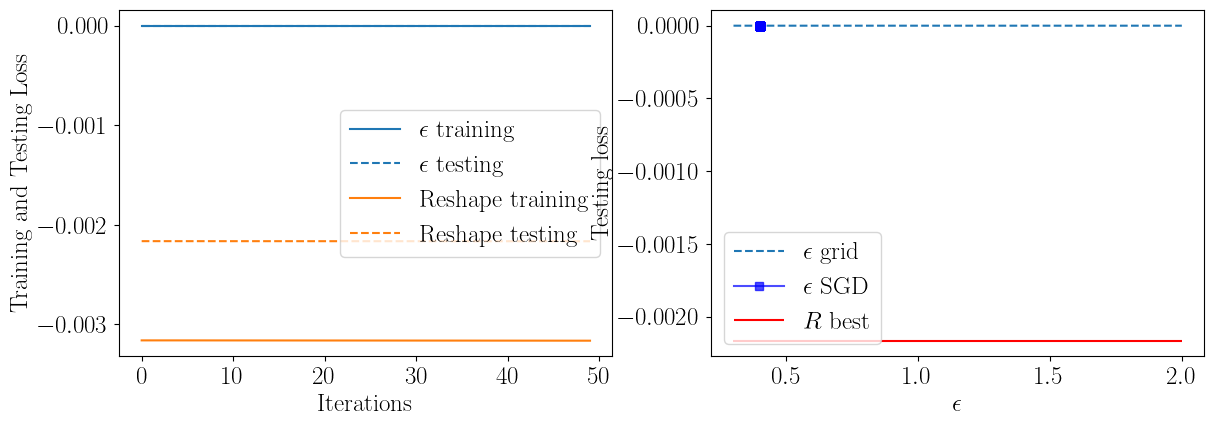

In [149]:

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5))
ax1.plot(df_eps['step'], df_eps['Loss_val'], color="tab:blue", label=r"$\epsilon$ training")
ax1.plot(df_eps['step'], df_eps['Eval_val'], linestyle='--', color="tab:blue", label=r"$\epsilon$ testing")
ax1.plot(df1['step'], df1['Loss_val'], color="tab:orange", label="Reshape training")
ax1.plot(df1['step'], df1['Eval_val'], linestyle='--', color="tab:orange", label="Reshape testing")
ax1.legend()
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Training and Testing Loss")

styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
ax2.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
ax2.plot(df_eps["A_norm"],df_eps["Eval_val"], linestyle='-', marker=styles[j], color = "blue", label="$\epsilon$ SGD",alpha = 0.7)
ax2.hlines( xmin = np.min(dfgrid["Eps"]), xmax = np.max(dfgrid["Eps"]), y = np.min(df1["Eval_val"]), label = "$R$ best", color= "red")   
ax2.set_xlabel("$\epsilon$")
ax2.set_ylabel("Testing loss")
ax2.legend()
plt.show()


### Example 3: Max of affine uncertainty
We consider a problem with max of affine uncertainty, 

$$g(u,x) = \max_{l=1,\dots,L} (P_lu + a_l)^Tx,$$
where $P_l$ and $a_l$ are constants for all $l = 1, \dots, L$. The robust formulation is 
$$
\begin{array}{ll}
\text{minimize} & \tau\\
\text{subject to}  & \max_{l=1,\dots,L} (P_lu + a_l)^Tx  \leq  \tau \quad \forall u \in \mathcal{U}(\theta)\\
& x \geq 0,
\end{array}
$$


where $\theta$ encodes the training parameters $(A,b)$.

In [223]:
# Formulate constants
n = 2
N = 50
# k = npr.uniform(1,4,n)
# p = k + npr.uniform(2,5,n)
k = np.array([4.,5.])
p = np.array([5,6.5])
k_tch = torch.tensor(k, requires_grad = True)
p_tch = torch.tensor(p, requires_grad = True)

k1 = np.array([0.5,1.])
p1 = np.array([3.,1.5])
k1_tch = torch.tensor(k1, requires_grad = True)
p1_tch = torch.tensor(p1, requires_grad = True)


b = npr.uniform(1,3,2)
b_tch = torch.tensor(b, requires_grad = True)
# Formulate loss function
def loss(t,y,x, x1, data,l = 5): 
    return t +y + l*torch.mean(torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t, 
        torch.tensor(0.,requires_grad = True)))+ l*torch.mean(torch.maximum(
        torch.maximum(k1_tch@x1 -data@p1_tch, k1_tch@x1 - p1_tch@x) - y, 
        torch.tensor(0.,requires_grad = True))), t+y, torch.mean(torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t, 
        torch.tensor(0.,requires_grad = True)))+ torch.mean(torch.maximum(
        torch.maximum(k1_tch@x1 -data@p1_tch, k1_tch@x1 - p1_tch@x) - y, 
        torch.tensor(0.,requires_grad = True)))
#+ torch.maximum(k_tch@(x - b_tch),torch.tensor(0.))
def gen_demand(n, N):
    F = np.random.normal(size = (n,2))
    sig = 0.1*F@(F.T)
    mu = np.random.uniform(-0.2,3,n)
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    return d_train

# Generate data
data = gen_demand(n,N)

In [200]:
# Formulate uncertainty set
# u = lro.UncertainParameter(n,
#                         uncertainty_set=lro.Ellipsoidal(p=2,
#                                                     data=data, loss = loss))
K = 5
u = lro.UncertainParameter(n,
                        uncertainty_set=lro.MRO(K = K, p=2,
                                                    data=data, loss = loss, uniqueA = True))
Astart = u.uncertainty_set._initA

# Formulate the Robust Problem
x_r = cp.Variable(n)
x_1 = cp.Variable(n)
t = cp.Variable()
y = cp.Variable()

objective = cp.Minimize(t+y)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [cp.maximum(k1@x_1 - p1@x_1, k1@x_1 - p1@u) <= y]

constraints += [x_r >= 0, x_r >= x_1]

prob = lro.RobustProblem(objective, constraints)

s = 13
# # Train only epsilon
# result = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", initeps = 1, seed = s)
# df_eps = result.df
# # Train A and b
# df1, newprob, A_fin, b_fin = prob.train(lr = 0.01, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initeps=1)

# # Grid search epsilon
# dfgrid, newprob = prob.grid(epslst = np.linspace(0.8, 2, 40), seed = s)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(data.T)))
init_b = -init@np.mean(data, axis=0)
# Train A and b
result1 = prob.train(lr = 0.001, step=200, momentum = 0.8, scheduler = True, optimizer = "SGD", seed = s, initA = init, initb = init_b, fixb = False)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

result2 = prob.train(eps = True, lr = 0.001, scheduler = True, step= 200, momentum = 0.8, optimizer = "SGD", seed = s, initA = A_fin, initb = b_fin)
df_r1 = result2.df

result3 = prob.train(eps = True, lr = 0.001, scheduler = True, step=200, momentum = 0.8, optimizer = "SGD", seed = s, initA = init, initb = init_b)
df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.001, 2, 40), initA = init, initb = init_b, seed = s)
dfgrid = result4.df

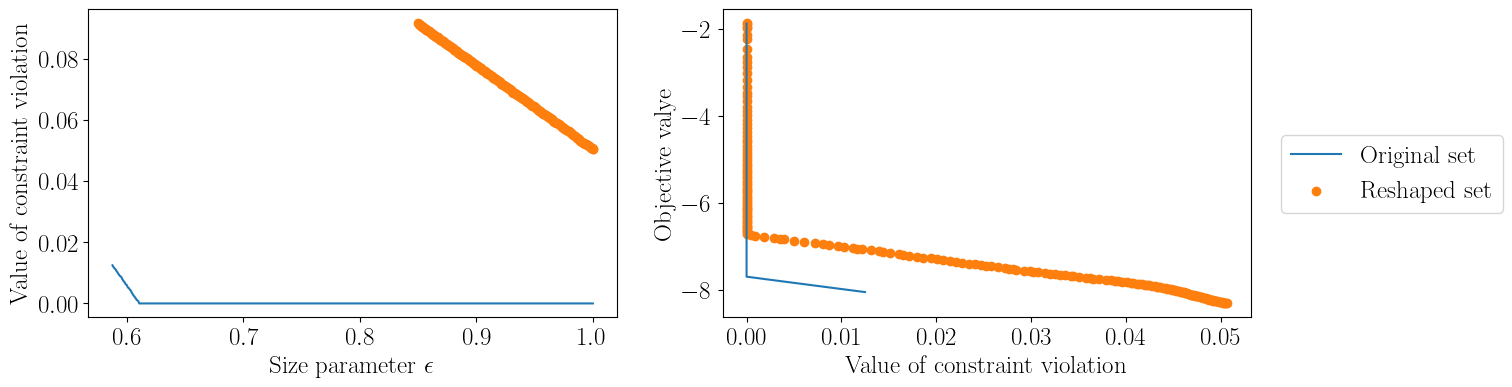

In [201]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot((df_r2['A_norm']), df_r2['Violations'], color="tab:blue", label=r"Original set")
ax1.scatter((df_r1['A_norm']), df_r1['Violations'], color="tab:orange", label="Reshaped set")
# ax1.set_yscale("log")
ax1.set_xlabel("Size parameter $\epsilon$")
ax1.set_ylabel("Value of constraint violation")

ax2.plot(df_r2['Violations'][:], df_r2['Test_val'][:], color="tab:blue", label=r"Original set")
ax2.scatter(df1['Violations'],df1['Test_val'], color="tab:orange", label="Reshaped set")
ax2.set_ylabel("Objective valye")
# ax2.set_xlim([-1,20])
ax2.set_xlabel("Value of constraint violation")
lgd = ax2.legend(loc = "lower right", bbox_to_anchor=(1.5, 0.3))
plt.savefig("ex1_curves.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


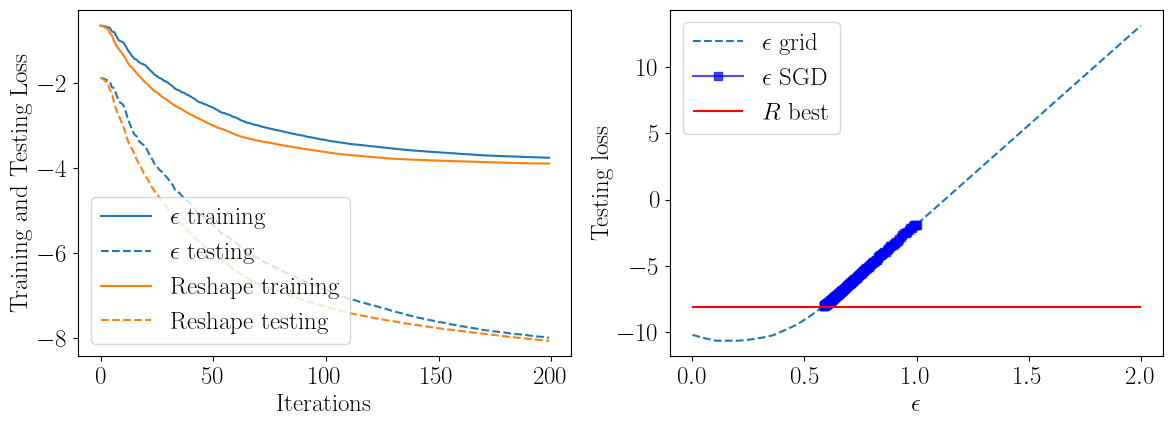

In [202]:

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5))
ax1.plot(df_r2['step'], df_r2['Loss_val'], color="tab:blue", label=r"$\epsilon$ training")
ax1.plot(df_r2['step'], df_r2['Eval_val'], linestyle='--', color="tab:blue", label=r"$\epsilon$ testing")
ax1.plot(df1['step'], df1['Loss_val'], color="tab:orange", label="Reshape training")
ax1.plot(df1['step'], df1['Eval_val'], linestyle='--', color="tab:orange", label="Reshape testing")
ax1.legend()
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Training and Testing Loss")

styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
ax2.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
ax2.plot(df_r2["A_norm"],df_r2["Eval_val"], linestyle='-', marker=styles[j], color = "blue", label="$\epsilon$ SGD",alpha = 0.7)

# ax2.plot(df1["A_norm"],df1["Eval_val"], linestyle='-', marker=styles[j], color = "green", label="$R$ SGD",alpha = 0.7)
ax2.hlines( xmin = np.min(dfgrid["Eps"]), xmax = np.max(dfgrid["Eps"]), y = np.min(df1["Eval_val"]), label = "$R$ best", color= "red")   
ax2.set_xlabel("$\epsilon$")
ax2.set_ylabel("Testing loss")
ax2.legend()
plt.show()


In [203]:
n = 2
u = lro.UncertainParameter(n,
                        uncertainty_set=lro.MRO(p=2,K = K,
                                                    A = result3.A,data = data, train = False, uniqueA = True))
# Formulate the Robust Problem
x_r = cp.Variable(n)
x_1 = cp.Variable(n)
t = cp.Variable()
y = cp.Variable()

objective = cp.Minimize(t+y)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [cp.maximum(k1@x_1 - p1@x_1, k1@x_1 - p1@u) <= y]

constraints += [x_r >= 0, x_r >= x_1]

prob = lro.RobustProblem(objective, constraints)
prob.solve()
# result3.reform_problem.solve()
x_opt_base = x_r.value
x_opt_base1 = x_1.value

t_base = t.value

n = 2
u = lro.UncertainParameter(n,
                        uncertainty_set=lro.MRO(p=2, K = K,
                                                    A = result2.A, data = data, train = False, uniqueA = True))
# Formulate the Robust Problem
x_r = cp.Variable(n)
x_1 = cp.Variable(n)
t = cp.Variable()
y = cp.Variable()

objective = cp.Minimize(t+y)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [cp.maximum(k1@x_1 - p1@x_1, k1@x_1 - p1@u) <= y]

constraints += [x_r >= 0, x_r >= x_1]
prob = lro.RobustProblem(objective, constraints)
prob.solve()
# result3.reform_problem.solve()
x_opt_learned = x_r.value
x_opt_learned1 = x_1.value

t_learned = t.value
x_opt_learned,x_opt_base,t_learned, t_base
# A_fin, init, b_fin, init_b

(array([ 6.13314690e+00, -2.43759351e-12]),
 array([ 6.13314690e+00, -3.59334689e-12]),
 array(0.88607691),
 array(1.64106778))

<Figure size 500x500 with 0 Axes>

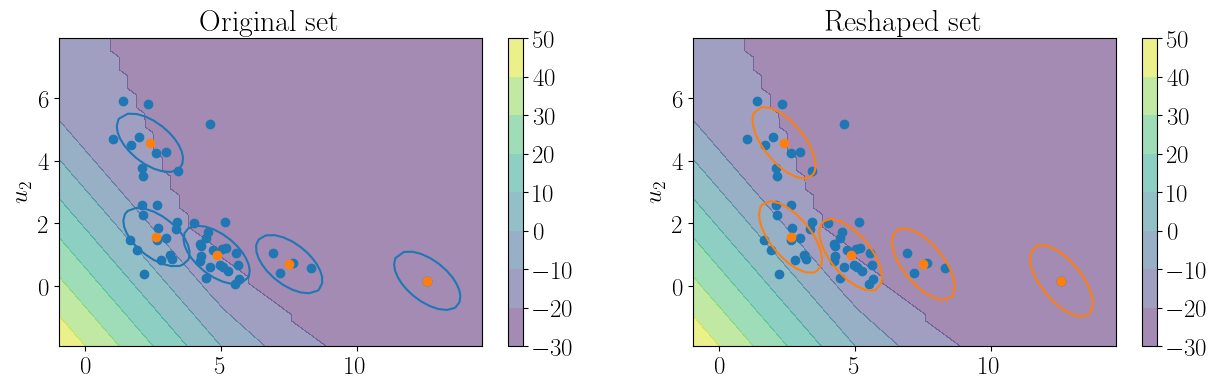

In [204]:
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

plt.figure(figsize=(5, 5))
num_p = 50
offset = 2
x_min, x_max = np.min(data[:,0]) - offset, np.max(data[:,0]) + offset
y_min, y_max = np.min(data[:,1]) - offset, np.max(data[:,1]) + offset
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)
# Z values as a matrix
fin_set = {}
init_set = {}
for k_ind in range(K):
    fin_set[k_ind] = np.zeros((num_p,num_p))
for k_ind in range(K):
    init_set[k_ind] = np.zeros((num_p,num_p))
      
# init_set = np.zeros((num_p,num_p))
g_level_learned = np.zeros((num_p,num_p))
g_level_base = np.zeros((num_p,num_p))
g_level_learned1 = np.zeros((num_p,num_p))
g_level_base1 = np.zeros((num_p,num_p))

# # Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
# for i in range(num_p):
#     for j in range(num_p):
#         u_vec = [x[i,j], y[i,j]]
#         fin_set[i,j] = np.linalg.norm(A_fin@ u_vec  + b_fin)
#         init_set[i,j] = np.linalg.norm(init@ u_vec + init_b)
#         g_level_learned[i,j] = np.maximum(k @ x_opt_learned - p @ x_opt_learned, k @ x_opt_learned - p @ u_vec)
#         g_level_base[i,j] = np.maximum(k @ x_opt_base - p @ x_opt_base, k @ x_opt_base - p @ u_vec)

# Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
for i in range(num_p):
    for j in range(num_p):
        u_vec = [x[i,j], y[i,j]]
        for k_ind in range(K):
            fin_set[k_ind][i,j] = np.linalg.norm(A_fin[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec  - A_fin[k_ind*n:(k_ind+1)*n, 0:n]@u.uncertainty_set.Dbar[k_ind])

        for k_ind in range(K):
            init_set[k_ind][i,j] = np.linalg.norm(result3.A[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec  - result3.A[k_ind*n:(k_ind+1)*n, 0:n]@u.uncertainty_set.Dbar[k_ind])
        # init_set[i,j] = np.linalg.norm(init@ u_vec - init@np.mean(data, axis = 0))
        g_level_learned[i,j] = np.maximum(k @ x_opt_learned - p @ x_opt_learned, k @ x_opt_learned - p @ u_vec)
        g_level_base[i,j] = np.maximum(k @ x_opt_base - p @ x_opt_base, k @ x_opt_base - p @ u_vec)
        g_level_learned1[i,j] = np.maximum(k1 @ x_opt_learned1 - p1 @ x_opt_learned1, k1 @ x_opt_learned1 - p1 @ u_vec)
        g_level_base1[i,j] = np.maximum(k1 @ x_opt_base1 - p1 @ x_opt_base1, k1 @ x_opt_base1 - p1 @ u_vec)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

ax1.set_title("Original set")
# Set x axis label for the contour plot
ax1.set_label(r"$u_1$")
# Set y axis label for the contour plot
import seaborn as sns
ax1.set_ylabel(r"$u_2$")
# plt.ylim(-20,40)
# plt.xlim(-20,40)
# for k_ind in range(K):
#     ax1.contour(x,y,fin_set[k_ind], [1], colors = ["tab:orange"])
for k_ind in range(K):
    ax1.contour(x,y,init_set[k_ind], [1], colors = ["tab:blue"])

# plt.contour(x,y,init_set, [1], colors = ["tab:blue"])
# plt.pcolormesh(g_level_learned, alpha = 0.5)
# plt.pcolormesh(g_level_base, alpha = 0.5)
# plt.contour(x,y,g_level_learned, [t_learned], colors = ["tab:orange"], labels = [-1])
# plt.contour(x,y,g_level_base, [t_base], colors = ["tab:blue"])

# a1 = plt.contour(x,y,g_level_learned, np.arange(-10,12,5), colors = ["tab:orange"], alpha = 0.8)
# b1 = plt.contour(x,y,g_level_base, np.arange(-10,12,5), colors = ["tab:blue"],alpha = 0.8)
# a2 = plt.contour(x,y,g_level_learned1, np.arange(-10,12,5), colors = ["tab:orange"], alpha = 0.8)
# b2 = plt.contour(x,y,g_level_base1, np.arange(-10,12,5), colors = ["tab:blue"],alpha = 0.8)

# plt.clabel(a1, a1.levels, inline=True, fmt=fmt, fontsize=18)
# plt.clabel(b1, b1.levels, inline=True, fmt=fmt, fontsize=18)
# plt.clabel(a2, a2.levels, inline=True, fmt=fmt, fontsize=18)
# plt.clabel(b2, b2.levels, inline=True, fmt=fmt, fontsize=18)

a1 = ax1.contourf(x,y,g_level_base+g_level_base1,alpha = 0.5)
# ax1.contourf(x,y,g_level_base1,alpha = 0.5)

ax1.scatter(data[:,0],data[:,1])
ax1.scatter(u.uncertainty_set.Dbar[:,0], u.uncertainty_set.Dbar[:,1])
fig.colorbar(a1, ax = ax1)


ax2.set_title("Reshaped set")
# Set x axis label for the contour plot
ax2.set_label(r"$u_1$")
# Set y axis label for the contour plot
import seaborn as sns
ax2.set_ylabel(r"$u_2$")
# plt.ylim(-20,40)
# plt.xlim(-20,40)
for k_ind in range(K):
    ax2.contour(x,y,fin_set[k_ind], [1], colors = ["tab:orange"])
# for k_ind in range(K):
#     ax1.contour(x,y,init_set[k_ind], [1], colors = ["tab:blue"])
a2 = ax2.contourf(x,y,g_level_learned +g_level_learned1 ,alpha = 0.5)
# ax2.contourf(x,y,g_level_learned1,alpha = 0.5)

ax2.scatter(data[:,0],data[:,1])
ax2.scatter(u.uncertainty_set.Dbar[:,0], u.uncertainty_set.Dbar[:,1])
fig.colorbar(a2,ax = ax2)

plt.savefig("Reshaped1.pdf", bbox_inches='tight')


In [205]:
# Formulate uncertainty set
# u = lro.UncertainParameter(n,
#                         uncertainty_set=lro.Ellipsoidal(p=2,
#                                                     data=data, loss = loss))
K = 5
u = lro.UncertainParameter(n,
                        uncertainty_set=lro.MRO(K = K, p=2,
                                                    data=data, loss = loss, uniqueA = True))
Astart = u.uncertainty_set._initA

# Formulate the Robust Problem
x_r = cp.Variable(n)
x_1 = cp.Variable(n)
t = cp.Variable()
y = cp.Variable()

objective = cp.Minimize(t+y)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [cp.maximum(k1@x_1 - p1@x_1, k1@x_1 - p1@u) <= y]

constraints += [x_r >= 0, x_r >= x_1]

prob = lro.RobustProblem(objective, constraints)

s = 13
# # Train only epsilon
# result = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", initeps = 1, seed = s)
# df_eps = result.df
# # Train A and b
# df1, newprob, A_fin, b_fin = prob.train(lr = 0.01, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initeps=1)

# # Grid search epsilon
# dfgrid, newprob = prob.grid(epslst = np.linspace(0.8, 2, 40), seed = s)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(data.T)))
init_b = -init@np.mean(data, axis=0)

# Train A and b
result1 = prob.train(lr = 0.001, step=200, momentum = 0.8, optimizer = "SGD", seed = s, initA = None, initb = init_b, fixb = False)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

result2 = prob.train(eps = True, lr = 0.001, step= 200, momentum = 0.8, optimizer = "SGD", seed = s, initA = A_fin, initb = b_fin)
df_r1 = result2.df

result3 = prob.train(eps = True, lr = 0.001, step=200, momentum = 0.8, optimizer = "SGD", seed = s, initA = None, initb = init_b )
df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.01, 3, 40), initA = None, initb = init_b, seed = s)
dfgrid = result4.df

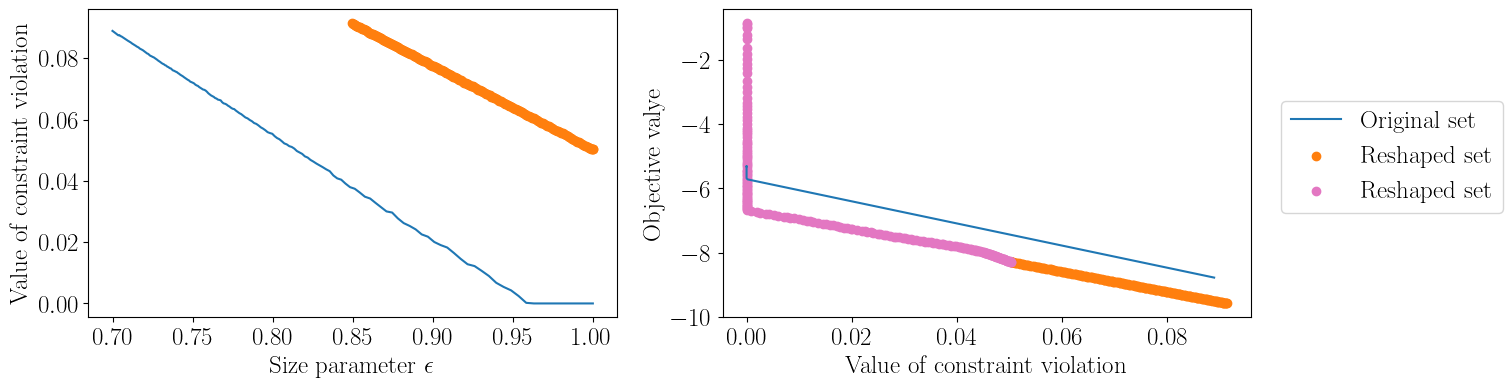

In [206]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot((df_r2['A_norm']), df_r2['Violations'], color="tab:blue", label=r"Original set")
ax1.scatter((df_r1['A_norm']), df_r1['Violations'], color="tab:orange", label="Reshaped set")
# ax1.set_yscale("log")
ax1.set_xlabel("Size parameter $\epsilon$")
ax1.set_ylabel("Value of constraint violation")

ax2.plot(df_r2['Violations'][:], df_r2['Test_val'][:], color="tab:blue", label=r"Original set")
ax2.scatter(df_r1['Violations'],df_r1['Test_val'], color="tab:orange", label="Reshaped set")
ax2.scatter(df1['Violations'],df1['Test_val'], color="tab:pink", label="Reshaped set")

ax2.set_ylabel("Objective valye")
# ax2.set_xlim([-1,20])
ax2.set_xlabel("Value of constraint violation")
lgd = ax2.legend(loc = "lower right", bbox_to_anchor=(1.5, 0.3))
plt.savefig("ex1_curves.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


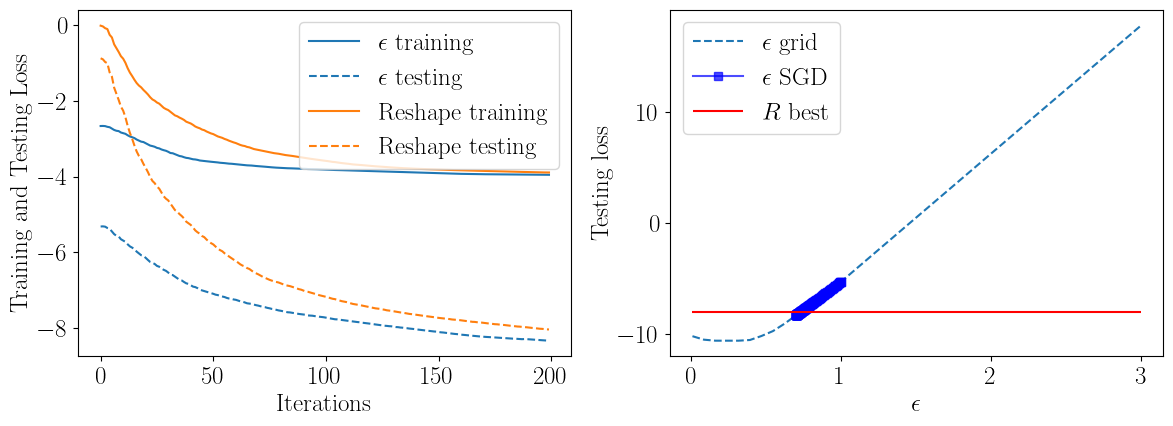

In [207]:

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5))
ax1.plot(df_r2['step'], df_r2['Loss_val'], color="tab:blue", label=r"$\epsilon$ training")
ax1.plot(df_r2['step'], df_r2['Eval_val'], linestyle='--', color="tab:blue", label=r"$\epsilon$ testing")
ax1.plot(df1['step'], df1['Loss_val'], color="tab:orange", label="Reshape training")
ax1.plot(df1['step'], df1['Eval_val'], linestyle='--', color="tab:orange", label="Reshape testing")
ax1.legend()
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Training and Testing Loss")

styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
ax2.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
ax2.plot(df_r2["A_norm"],df_r2["Eval_val"], linestyle='-', marker=styles[j], color = "blue", label="$\epsilon$ SGD",alpha = 0.7)

# ax2.plot(df1["A_norm"],df1["Eval_val"], linestyle='-', marker=styles[j], color = "green", label="$R$ SGD",alpha = 0.7)
ax2.hlines( xmin = np.min(dfgrid["Eps"]), xmax = np.max(dfgrid["Eps"]), y = np.min(df1["Eval_val"]), label = "$R$ best", color= "red")   
ax2.set_xlabel("$\epsilon$")
ax2.set_ylabel("Testing loss")
ax2.legend()
plt.show()


In [208]:
n = 2
u = lro.UncertainParameter(n,
                        uncertainty_set=lro.MRO(p=2,K = K,
                                                    A = Astart,data = data, train = False, uniqueA = True))
# Formulate the Robust Problem
x_r = cp.Variable(n)
x_1 = cp.Variable(n)
t = cp.Variable()
y = cp.Variable()

objective = cp.Minimize(t+y)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [cp.maximum(k1@x_1 - p1@x_1, k1@x_1 - p1@u) <= y]

constraints += [x_r >= 0, x_r >= x_1, x_1 >= 0]


prob = lro.RobustProblem(objective, constraints)
prob.solve()
# result3.reform_problem.solve()
x_opt_base = x_r.value
x_opt_base1 = x_1.value

t_base = t.value

n = 2
u = lro.UncertainParameter(n,
                        uncertainty_set=lro.MRO(p=2, K = K,
                                                    A = A_fin, data = data, train = False, uniqueA = True))
# Formulate the Robust Problem
x_r = cp.Variable(n)
x_1 = cp.Variable(n)
t = cp.Variable()
y = cp.Variable()

objective = cp.Minimize(t+y)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [cp.maximum(k1@x_1 - p1@x_1, k1@x_1 - p1@u) <= y]

constraints += [x_r >= 0, x_r >= x_1, x_1 >= 0]


prob = lro.RobustProblem(objective, constraints)
prob.solve()
# result3.reform_problem.solve()
x_opt_learned = x_r.value
x_opt_learned1 = x_1.value
t_learned = t.value
x_opt_learned,x_opt_base,t_learned, t_base
# A_fin, init, b_fin, init_b

(array([ 6.13314690e+00, -1.35345495e-11]),
 array([6.13314690e+00, 1.44609675e-11]),
 array(1.78378069),
 array(5.63761642))

<Figure size 500x500 with 0 Axes>

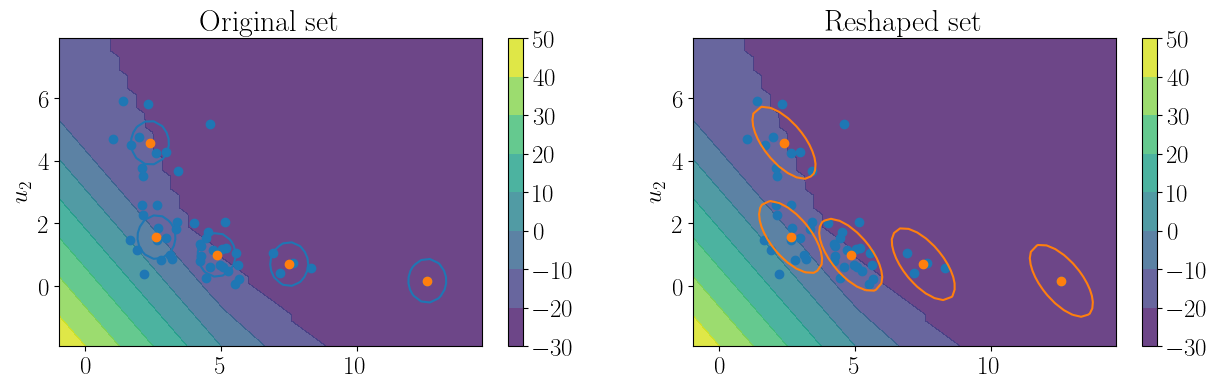

In [209]:
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

plt.figure(figsize=(5, 5))
num_p = 50
offset = 2
x_min, x_max = np.min(data[:,0]) - offset, np.max(data[:,0]) + offset
y_min, y_max = np.min(data[:,1]) - offset, np.max(data[:,1]) + offset
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)
# Z values as a matrix
fin_set = {}
init_set = {}
for k_ind in range(K):
    fin_set[k_ind] = np.zeros((num_p,num_p))
for k_ind in range(K):
    init_set[k_ind] = np.zeros((num_p,num_p))
      
# init_set = np.zeros((num_p,num_p))
g_level_learned = np.zeros((num_p,num_p))
g_level_base = np.zeros((num_p,num_p))
g_level_learned1 = np.zeros((num_p,num_p))
g_level_base1 = np.zeros((num_p,num_p))

# # Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
# for i in range(num_p):
#     for j in range(num_p):
#         u_vec = [x[i,j], y[i,j]]
#         fin_set[i,j] = np.linalg.norm(A_fin@ u_vec  + b_fin)
#         init_set[i,j] = np.linalg.norm(init@ u_vec + init_b)
#         g_level_learned[i,j] = np.maximum(k @ x_opt_learned - p @ x_opt_learned, k @ x_opt_learned - p @ u_vec)
#         g_level_base[i,j] = np.maximum(k @ x_opt_base - p @ x_opt_base, k @ x_opt_base - p @ u_vec)

# Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
for i in range(num_p):
    for j in range(num_p):
        u_vec = [x[i,j], y[i,j]]
        for k_ind in range(K):
            fin_set[k_ind][i,j] = np.linalg.norm(A_fin[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec  - A_fin[k_ind*n:(k_ind+1)*n, 0:n]@u.uncertainty_set.Dbar[k_ind])

        for k_ind in range(K):
            init_set[k_ind][i,j] = np.linalg.norm(result3.A[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec  - result3.A[k_ind*n:(k_ind+1)*n, 0:n]@u.uncertainty_set.Dbar[k_ind])
        # init_set[i,j] = np.linalg.norm(init@ u_vec - init@np.mean(data, axis = 0))
        g_level_learned[i,j] = np.maximum(k @ x_opt_learned - p @ x_opt_learned, k @ x_opt_learned - p @ u_vec)
        g_level_base[i,j] = np.maximum(k @ x_opt_base - p @ x_opt_base, k @ x_opt_base - p @ u_vec)
        g_level_learned1[i,j] = np.maximum(k1 @ x_opt_learned1 - p1 @ x_opt_learned1, k1 @ x_opt_learned1 - p1 @ u_vec)
        g_level_base1[i,j] = np.maximum(k1 @ x_opt_base1 - p1 @ x_opt_base1, k1 @ x_opt_base1 - p1 @ u_vec)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

ax1.set_title("Original set")
# Set x axis label for the contour plot
ax1.set_label(r"$u_1$")
# Set y axis label for the contour plot
import seaborn as sns
ax1.set_ylabel(r"$u_2$")
# plt.ylim(-20,40)
# plt.xlim(-20,40)
# for k_ind in range(K):
#     ax1.contour(x,y,fin_set[k_ind], [1], colors = ["tab:orange"])
for k_ind in range(K):
    ax1.contour(x,y,init_set[k_ind], [1], colors = ["tab:blue"])

# plt.contour(x,y,init_set, [1], colors = ["tab:blue"])
# plt.pcolormesh(g_level_learned, alpha = 0.5)
# plt.pcolormesh(g_level_base, alpha = 0.5)
# plt.contour(x,y,g_level_learned, [t_learned], colors = ["tab:orange"], labels = [-1])
# plt.contour(x,y,g_level_base, [t_base], colors = ["tab:blue"])

# a1 = plt.contour(x,y,g_level_learned, np.arange(-10,12,5), colors = ["tab:orange"], alpha = 0.8)
# b1 = plt.contour(x,y,g_level_base, np.arange(-10,12,5), colors = ["tab:blue"],alpha = 0.8)
# a2 = plt.contour(x,y,g_level_learned1, np.arange(-10,12,5), colors = ["tab:orange"], alpha = 0.8)
# b2 = plt.contour(x,y,g_level_base1, np.arange(-10,12,5), colors = ["tab:blue"],alpha = 0.8)

# plt.clabel(a1, a1.levels, inline=True, fmt=fmt, fontsize=18)
# plt.clabel(b1, b1.levels, inline=True, fmt=fmt, fontsize=18)
# plt.clabel(a2, a2.levels, inline=True, fmt=fmt, fontsize=18)
# plt.clabel(b2, b2.levels, inline=True, fmt=fmt, fontsize=18)

a1 = ax1.contourf(x,y,g_level_base+g_level_base1,alpha = 0.8)
# ax1.contourf(x,y,g_level_base1,alpha = 0.5)

ax1.scatter(data[:,0],data[:,1])
ax1.scatter(u.uncertainty_set.Dbar[:,0], u.uncertainty_set.Dbar[:,1])
fig.colorbar(a1, ax = ax1)


ax2.set_title("Reshaped set")
# Set x axis label for the contour plot
ax2.set_label(r"$u_1$")
# Set y axis label for the contour plot
import seaborn as sns
ax2.set_ylabel(r"$u_2$")
# plt.ylim(-20,40)
# plt.xlim(-20,40)
for k_ind in range(K):
    ax2.contour(x,y,fin_set[k_ind], [1], colors = ["tab:orange"])
# for k_ind in range(K):
#     ax1.contour(x,y,init_set[k_ind], [1], colors = ["tab:blue"])
a2 = ax2.contourf(x,y,g_level_learned + g_level_learned1 ,alpha = 0.8)
# ax2.contourf(x,y,g_level_learned1,alpha = 0.5)

ax2.scatter(data[:,0],data[:,1])
ax2.scatter(u.uncertainty_set.Dbar[:,0], u.uncertainty_set.Dbar[:,1])
fig.colorbar(a2,ax = ax2)

plt.savefig("Reshaped1.pdf", bbox_inches='tight')


In [301]:
# Formulate constants
n = 2
N = 50
# k = npr.uniform(1,4,n)
# p = k + npr.uniform(2,5,n)
k = np.array([4.,5.])
p = np.array([5,6.5])
k_tch = torch.tensor(k, requires_grad = True)
p_tch = torch.tensor(p, requires_grad = True)

k1 = np.array([1.,1.])
p1 = np.array([4.,1.5])
k1_tch = torch.tensor(k1, requires_grad = True)
p1_tch = torch.tensor(p1, requires_grad = True)


b = npr.uniform(1,3,2)
b_tch = torch.tensor(b, requires_grad = True)
# Formulate loss function
def loss(t,y,x, x1, data,l = 5): 
    return t +y + l*torch.mean(torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t, 
        torch.tensor(0.,requires_grad = True)))+ l*torch.mean(torch.maximum(
        torch.maximum(k1_tch@x1 -data@p1_tch, k1_tch@x1 - p1_tch@x) - y, 
        torch.tensor(0.,requires_grad = True))), t+y, torch.mean(torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t, 
        torch.tensor(0.,requires_grad = True)))+ torch.mean(torch.maximum(
        torch.maximum(k1_tch@x1 -data@p1_tch, k1_tch@x1 - p1_tch@x) - y, 
        torch.tensor(0.,requires_grad = True)))
#+ torch.maximum(k_tch@(x - b_tch),torch.tensor(0.))
def gen_demand(n, N):
    F = np.random.normal(size = (n,2))
    sig = 0.1*F@(F.T)
    mu = np.random.uniform(-0.2,3,n)
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    return d_train

# Generate data
data = gen_demand(n,N)

In [302]:
# Formulate uncertainty set
u = lro.UncertainParameter(n,
                        uncertainty_set=lro.Ellipsoidal(p=2,
                                                    data=data, loss = loss))
# Formulate the Robust Problem
x_r = cp.Variable(n)
x_1 = cp.Variable(n)
t = cp.Variable()
y = cp.Variable()

objective = cp.Minimize(t+y)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [cp.maximum(k1@x_1 - p1@x_1, k1@x_1 - p1@u) <= y]

constraints += [x_r >= 0, x_r >= x_1, x_1 >= 0]

prob = lro.RobustProblem(objective, constraints)

s = 13
# # Train only epsilon
# result = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", initeps = 1, seed = s)
# df_eps = result.df
# # Train A and b
# df1, newprob, A_fin, b_fin = prob.train(lr = 0.01, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initeps=1)

# # Grid search epsilon
# dfgrid, newprob = prob.grid(epslst = np.linspace(0.8, 2, 40), seed = s)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(data.T)))
init_b = -init@np.mean(data, axis=0)
# Train A and b
result1 = prob.train(lr = 0.001, step=100, momentum = 0.8, optimizer = "SGD", seed = s, initA = init, initb = init_b, fixb = False)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

result2 = prob.train(eps = True, lr = 0.001, step= 100, momentum = 0.8, optimizer = "SGD", seed = s, initA = A_fin, initb = b_fin)
df_r1 = result2.df

result3 = prob.train(eps = True, lr = 0.001, step=100, momentum = 0.8, optimizer = "SGD", seed = s, initA = init, initb = init_b )
df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.01, 3, 40), initA = init, initb = init_b, seed = s)
dfgrid = result4.df

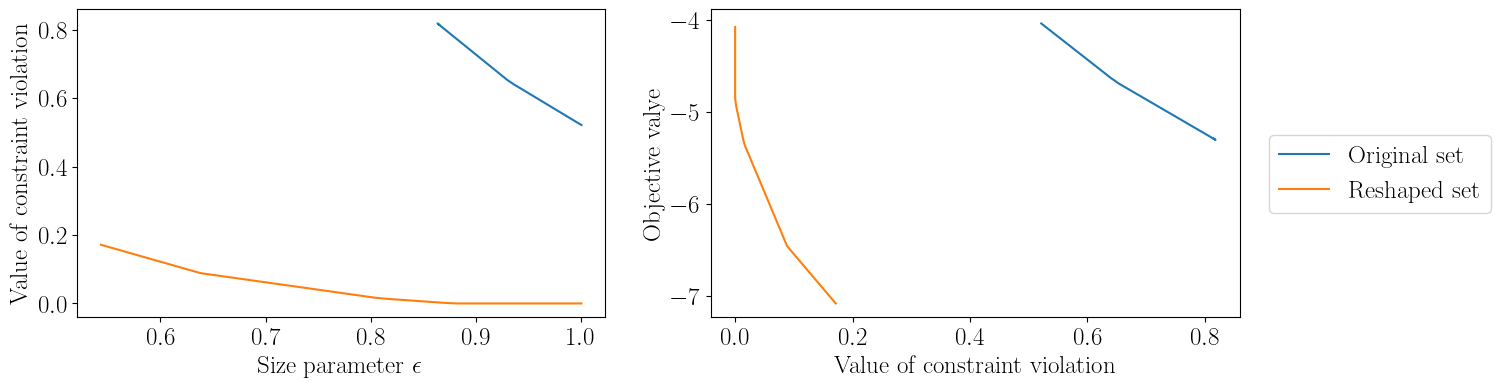

In [303]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot((df_r2['A_norm']), df_r2['Violations'], color="tab:blue", label=r"Original set")
ax1.plot((df_r1['A_norm']), df_r1['Violations'], color="tab:orange", label="Reshaped set")
# ax1.set_yscale("log")
ax1.set_xlabel("Size parameter $\epsilon$")
ax1.set_ylabel("Value of constraint violation")

ax2.plot(df_r2['Violations'][:], df_r2['Test_val'][:], color="tab:blue", label=r"Original set")
ax2.plot(df_r1['Violations'],df_r1['Test_val'], color="tab:orange", label="Reshaped set")
ax2.set_ylabel("Objective valye")
# ax2.set_xlim([-1,20])
ax2.set_xlabel("Value of constraint violation")
lgd = ax2.legend(loc = "lower right", bbox_to_anchor=(1.5, 0.3))
plt.savefig("ex1_curves.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


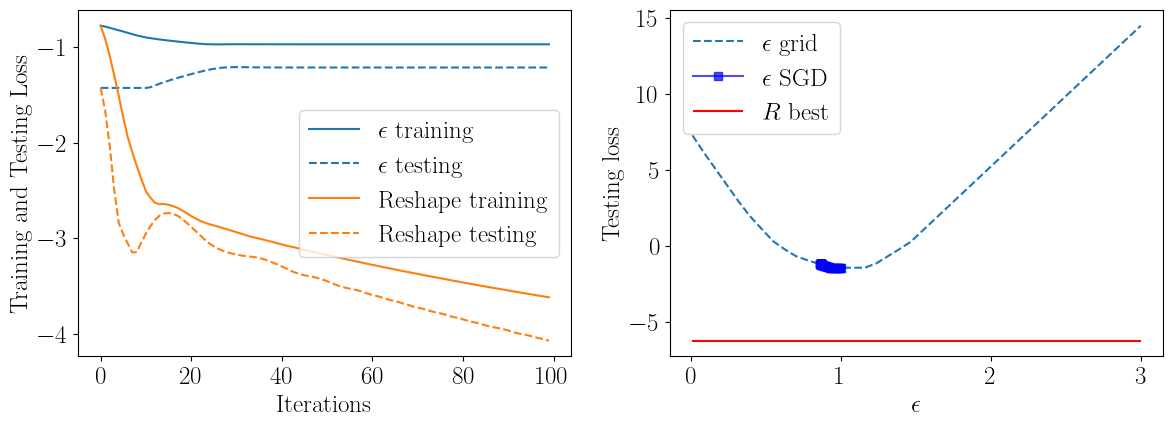

In [304]:

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5))
ax1.plot(df_r2['step'], df_r2['Loss_val'], color="tab:blue", label=r"$\epsilon$ training")
ax1.plot(df_r2['step'], df_r2['Eval_val'], linestyle='--', color="tab:blue", label=r"$\epsilon$ testing")
ax1.plot(df1['step'], df1['Loss_val'], color="tab:orange", label="Reshape training")
ax1.plot(df1['step'], df1['Eval_val'], linestyle='--', color="tab:orange", label="Reshape testing")
ax1.legend()
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Training and Testing Loss")

styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
ax2.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
ax2.plot(df_r2["A_norm"],df_r2["Eval_val"], linestyle='-', marker=styles[j], color = "blue", label="$\epsilon$ SGD",alpha = 0.7)

# ax2.plot(df_r1["A_norm"],df_r1["Eval_val"], linestyle='-', marker=styles[j], color = "green", label="$R$ SGD",alpha = 0.7)
ax2.hlines( xmin = np.min(dfgrid["Eps"]), xmax = np.max(dfgrid["Eps"]), y = np.min(df_r1["Eval_val"]), label = "$R$ best", color= "red")   
ax2.set_xlabel("$\epsilon$")
ax2.set_ylabel("Testing loss")
ax2.legend()
plt.show()


In [305]:
n = 2
u = lro.UncertainParameter(n,
                        uncertainty_set=lro.Ellipsoidal(p=2,
                                                    A = init, b = init_b))
# Formulate the Robust Problem
x_r = cp.Variable(n)
x_1 = cp.Variable(n)
t = cp.Variable()
y = cp.Variable()

objective = cp.Minimize(t+y)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [cp.maximum(k1@x_1 - p1@x_1, k1@x_1 - p1@u) <= y]

constraints += [x_r >= 0, x_r >= x_1, x_1 >= 0]

prob = lro.RobustProblem(objective, constraints)
prob.solve()
# result3.reform_problem.solve()
x_opt_base = x_r.value
x_opt_base1 = x_1.value

t_base = t.value

n = 2
u = lro.UncertainParameter(n,
                        uncertainty_set=lro.Ellipsoidal(p=2,
                                                    A = A_fin, b = b_fin))
# Formulate the Robust Problem
x_r = cp.Variable(n)
x_1 = cp.Variable(n)
t = cp.Variable()
y = cp.Variable()

objective = cp.Minimize(t+y)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [cp.maximum(k1@x_1 - p1@x_1, k1@x_1 - p1@u) <= y]

constraints += [x_r >= 0, x_r >= x_1, x_1 >= 0]

prob = lro.RobustProblem(objective, constraints)
prob.solve()
# result3.reform_problem.solve()
x_opt_learned = x_r.value
x_opt_learned1 = x_1.value

t_learned = t.value
x_opt_learned,x_opt_base,x_opt_learned1,x_opt_base1,t_learned, t_base
# A_fin, init, b_fin, init_b

(array([2.08388268, 1.55463981]),
 array([2.48120111, 2.2482048 ]),
 array([2.08388268e+00, 5.53933223e-11]),
 array([2.48120111e+00, 1.85268132e-10]),
 array(0.01288771),
 array(0.54079519))

<Figure size 500x500 with 0 Axes>

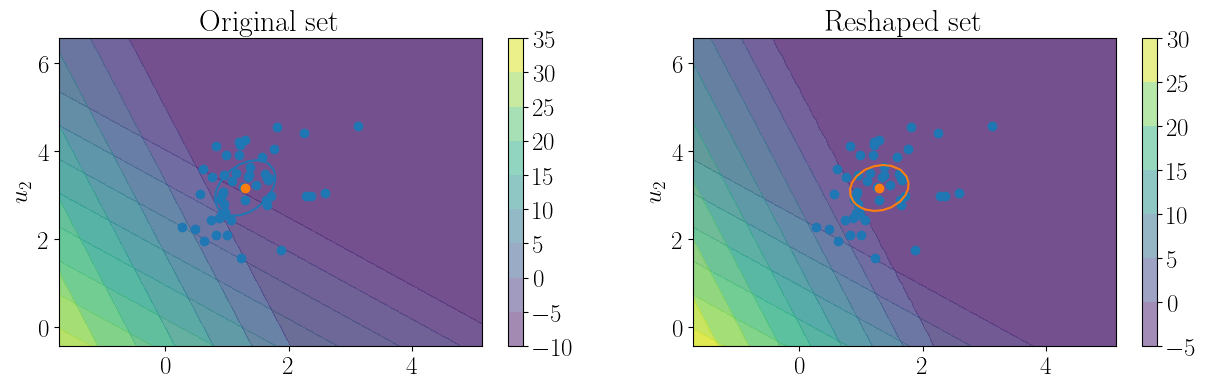

In [306]:
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

plt.figure(figsize=(5, 5))
num_p = 50
offset = 2
x_min, x_max = np.min(data[:,0]) - offset, np.max(data[:,0]) + offset
y_min, y_max = np.min(data[:,1]) - offset, np.max(data[:,1]) + offset
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)
# Z values as a matrix
fin_set = {}
init_set = {}
for k_ind in range(K):
    fin_set[k_ind] = np.zeros((num_p,num_p))
for k_ind in range(K):
    init_set[k_ind] = np.zeros((num_p,num_p))
      
# init_set = np.zeros((num_p,num_p))
g_level_learned = np.zeros((num_p,num_p))
g_level_base = np.zeros((num_p,num_p))
g_level_learned1 = np.zeros((num_p,num_p))
g_level_base1 = np.zeros((num_p,num_p))

# # Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
# for i in range(num_p):
#     for j in range(num_p):
#         u_vec = [x[i,j], y[i,j]]
#         fin_set[i,j] = np.linalg.norm(A_fin@ u_vec  + b_fin)
#         init_set[i,j] = np.linalg.norm(init@ u_vec + init_b)
#         g_level_learned[i,j] = np.maximum(k @ x_opt_learned - p @ x_opt_learned, k @ x_opt_learned - p @ u_vec)
#         g_level_base[i,j] = np.maximum(k @ x_opt_base - p @ x_opt_base, k @ x_opt_base - p @ u_vec)

# Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
for i in range(num_p):
    for j in range(num_p):
        u_vec = [x[i,j], y[i,j]]
        for k_ind in range(K):
            fin_set[k_ind][i,j] = np.linalg.norm(A_fin[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec  - A_fin[k_ind*n:(k_ind+1)*n, 0:n]@np.mean(data, axis = 0))

        for k_ind in range(K):
            init_set[k_ind][i,j] = np.linalg.norm(result3.A[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec  - result3.A[k_ind*n:(k_ind+1)*n, 0:n]@np.mean(data, axis = 0))
        # init_set[i,j] = np.linalg.norm(init@ u_vec - init@np.mean(data, axis = 0))
        g_level_learned[i,j] = np.maximum(k @ x_opt_learned - p @ x_opt_learned, k @ x_opt_learned - p @ u_vec)
        g_level_base[i,j] = np.maximum(k @ x_opt_base - p @ x_opt_base, k @ x_opt_base - p @ u_vec)
        g_level_learned1[i,j] = np.maximum(k1 @ x_opt_learned1 - p1 @ x_opt_learned1, k1 @ x_opt_learned1 - p1 @ u_vec)
        g_level_base1[i,j] = np.maximum(k1 @ x_opt_base1 - p1 @ x_opt_base1, k1 @ x_opt_base1 - p1 @ u_vec)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

ax1.set_title("Original set")
# Set x axis label for the contour plot
ax1.set_label(r"$u_1$")
# Set y axis label for the contour plot
import seaborn as sns
ax1.set_ylabel(r"$u_2$")
# plt.ylim(-20,40)
# plt.xlim(-20,40)
# for k_ind in range(K):
#     ax1.contour(x,y,fin_set[k_ind], [1], colors = ["tab:orange"])
for k_ind in range(K):
    ax1.contour(x,y,init_set[k_ind], [1], colors = ["tab:blue"])

# plt.contour(x,y,init_set, [1], colors = ["tab:blue"])
# plt.pcolormesh(g_level_learned, alpha = 0.5)
# plt.pcolormesh(g_level_base, alpha = 0.5)
# plt.contour(x,y,g_level_learned, [t_learned], colors = ["tab:orange"], labels = [-1])
# plt.contour(x,y,g_level_base, [t_base], colors = ["tab:blue"])

# a1 = plt.contour(x,y,g_level_learned, np.arange(-10,12,5), colors = ["tab:orange"], alpha = 0.8)
# b1 = plt.contour(x,y,g_level_base, np.arange(-10,12,5), colors = ["tab:blue"],alpha = 0.8)
# a2 = plt.contour(x,y,g_level_learned1, np.arange(-10,12,5), colors = ["tab:orange"], alpha = 0.8)
# b2 = plt.contour(x,y,g_level_base1, np.arange(-10,12,5), colors = ["tab:blue"],alpha = 0.8)

# plt.clabel(a1, a1.levels, inline=True, fmt=fmt, fontsize=18)
# plt.clabel(b1, b1.levels, inline=True, fmt=fmt, fontsize=18)
# plt.clabel(a2, a2.levels, inline=True, fmt=fmt, fontsize=18)
# plt.clabel(b2, b2.levels, inline=True, fmt=fmt, fontsize=18)

a1 = ax1.contourf(x,y,g_level_base,alpha = 0.5)
ax1.contourf(x,y,g_level_base1,alpha = 0.5)

ax1.scatter(data[:,0],data[:,1])
ax1.scatter(np.mean(data,axis= 0)[0], np.mean(data,axis= 0)[1])
fig.colorbar(a1, ax = ax1)


ax2.set_title("Reshaped set")
# Set x axis label for the contour plot
ax2.set_label(r"$u_1$")
# Set y axis label for the contour plot
import seaborn as sns
ax2.set_ylabel(r"$u_2$")
# plt.ylim(-20,40)
# plt.xlim(-20,40)
for k_ind in range(K):
    ax2.contour(x,y,fin_set[k_ind], [1], colors = ["tab:orange"])
# for k_ind in range(K):
#     ax1.contour(x,y,init_set[k_ind], [1], colors = ["tab:blue"])
a2 = ax2.contourf(x,y,g_level_learned,alpha = 0.5)
ax2.contourf(x,y,g_level_learned1,alpha = 0.5)

ax2.scatter(data[:,0],data[:,1])
ax2.scatter(np.mean(data,axis= 0)[0], np.mean(data,axis= 0)[1])
fig.colorbar(a2,ax = ax2)

plt.savefig("Reshaped1.pdf", bbox_inches='tight')


<Figure size 500x500 with 0 Axes>

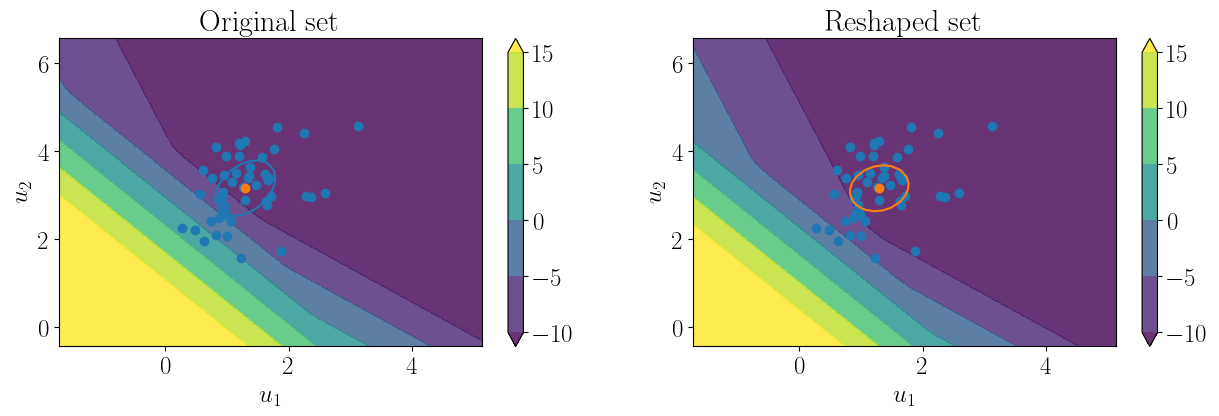

In [308]:
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

plt.figure(figsize=(5, 5))
num_p = 50
offset = 2
x_min, x_max = np.min(data[:,0]) - offset, np.max(data[:,0]) + offset
y_min, y_max = np.min(data[:,1]) - offset, np.max(data[:,1]) + offset
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)
# Z values as a matrix
fin_set = {}
init_set = {}
for k_ind in range(K):
    fin_set[k_ind] = np.zeros((num_p,num_p))
for k_ind in range(K):
    init_set[k_ind] = np.zeros((num_p,num_p))
      
# init_set = np.zeros((num_p,num_p))
g_level_learned = np.zeros((num_p,num_p))
g_level_base = np.zeros((num_p,num_p))
g_level_learned1 = np.zeros((num_p,num_p))
g_level_base1 = np.zeros((num_p,num_p))

# # Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
# for i in range(num_p):
#     for j in range(num_p):
#         u_vec = [x[i,j], y[i,j]]
#         fin_set[i,j] = np.linalg.norm(A_fin@ u_vec  + b_fin)
#         init_set[i,j] = np.linalg.norm(init@ u_vec + init_b)
#         g_level_learned[i,j] = np.maximum(k @ x_opt_learned - p @ x_opt_learned, k @ x_opt_learned - p @ u_vec)
#         g_level_base[i,j] = np.maximum(k @ x_opt_base - p @ x_opt_base, k @ x_opt_base - p @ u_vec)

# Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
for i in range(num_p):
    for j in range(num_p):
        u_vec = [x[i,j], y[i,j]]
        for k_ind in range(K):
            fin_set[k_ind][i,j] = np.linalg.norm(A_fin[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec  - A_fin[k_ind*n:(k_ind+1)*n, 0:n]@np.mean(data, axis = 0))

        for k_ind in range(K):
            init_set[k_ind][i,j] = np.linalg.norm(result3.A[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec  - result3.A[k_ind*n:(k_ind+1)*n, 0:n]@np.mean(data, axis = 0))
        # init_set[i,j] = np.linalg.norm(init@ u_vec - init@np.mean(data, axis = 0))
        g_level_learned[i,j] = np.maximum(k @ x_opt_learned - p @ x_opt_learned, k @ x_opt_learned - p @ u_vec) + np.maximum(k1 @ x_opt_learned1 - p1 @ x_opt_learned1, k1 @ x_opt_learned1 - p1 @ u_vec)
        g_level_base[i,j] = np.maximum(k @ x_opt_base - p @ x_opt_base, k @ x_opt_base - p @ u_vec) + np.maximum(k1 @ x_opt_base1 - p1 @ x_opt_base1, k1 @ x_opt_base1 - p1 @ u_vec)
        g_level_learned1[i,j] = np.maximum(k1 @ x_opt_learned1 - p1 @ x_opt_learned1, k1 @ x_opt_learned1 - p1 @ u_vec)
        g_level_base1[i,j] = np.maximum(k1 @ x_opt_base1 - p1 @ x_opt_base1, k1 @ x_opt_base1 - p1 @ u_vec)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

ax1.set_title("Original set")
# Set x axis label for the contour plot
ax1.set_xlabel(r"$u_1$")
# Set y axis label for the contour plot
import seaborn as sns
ax1.set_ylabel(r"$u_2$")
# plt.ylim(-20,40)
# plt.xlim(-20,40)
# for k_ind in range(K):
#     ax1.contour(x,y,fin_set[k_ind], [1], colors = ["tab:orange"])
for k_ind in range(K):
    ax1.contour(x,y,init_set[k_ind], [1], colors = ["tab:blue"])

# plt.contour(x,y,init_set, [1], colors = ["tab:blue"])
# plt.pcolormesh(g_level_learned, alpha = 0.5)
# plt.pcolormesh(g_level_base, alpha = 0.5)
# plt.contour(x,y,g_level_learned, [t_learned], colors = ["tab:orange"], labels = [-1])
# plt.contour(x,y,g_level_base, [t_base], colors = ["tab:blue"])

# a1 = plt.contour(x,y,g_level_learned, np.arange(-10,12,5), colors = ["tab:orange"], alpha = 0.8)
# b1 = plt.contour(x,y,g_level_base, np.arange(-10,12,5), colors = ["tab:blue"],alpha = 0.8)
# a2 = plt.contour(x,y,g_level_learned1, np.arange(-10,12,5), colors = ["tab:orange"], alpha = 0.8)
# b2 = plt.contour(x,y,g_level_base1, np.arange(-10,12,5), colors = ["tab:blue"],alpha = 0.8)

# plt.clabel(a1, a1.levels, inline=True, fmt=fmt, fontsize=18)
# plt.clabel(b1, b1.levels, inline=True, fmt=fmt, fontsize=18)
# plt.clabel(a2, a2.levels, inline=True, fmt=fmt, fontsize=18)
# plt.clabel(b2, b2.levels, inline=True, fmt=fmt, fontsize=18)

a1 = ax1.contourf(x,y,g_level_base,np.arange(-10, 20, 5),extend='both',alpha = 0.8)
# ax1.contourf(x,y,g_level_base1,alpha = 0.5)

ax1.scatter(data[:,0],data[:,1])
ax1.scatter(np.mean(data,axis= 0)[0], np.mean(data,axis= 0)[1])
aa = fig.colorbar(a1, ax = ax1)

ax2.set_title("Reshaped set")
# Set x axis label for the contour plot
ax2.set_xlabel(r"$u_1$")
# Set y axis label for the contour plot
import seaborn as sns
ax2.set_ylabel(r"$u_2$")
# plt.ylim(-20,40)
# plt.xlim(-20,40)
for k_ind in range(K):
    ax2.contour(x,y,fin_set[k_ind], [1], colors = ["tab:orange"])
# for k_ind in range(K):
#     ax1.contour(x,y,init_set[k_ind], [1], colors = ["tab:blue"])
a2 = ax2.contourf(x,y,g_level_learned,np.arange(-10, 20, 5),extend='both',alpha = 0.8)
# ax2.contourf(x,y,g_level_learned1,alpha = 0.5)

ax2.scatter(data[:,0],data[:,1])
ax2.scatter(np.mean(data,axis= 0)[0], np.mean(data,axis= 0)[1])
fig.colorbar(a2,ax = ax2, boundaries=np.linspace(-10,20,10))
plt.savefig("Reshaped1.pdf", bbox_inches='tight')


### Example 4: Affine Adjustable Robust Optimization: Inventory management

We solve the robust optimization problem given as 
\begin{equation*}
	\begin{array}{ll}
		\text{minimize} & L\\
		\text{subject to} & -r^Ty^0 - r^TYu + (t+h)^Ts \le L, \quad \forall u\in \mathcal{U}(\mathcal{D}_N,\theta)\\
		& y^0_i + y_i^Tu\leq s_i, \quad i = 1, \dots, N, \quad \forall u\in \mathcal{U}(\mathcal{D}_N,\theta)\\
		& y^0_i + y_i^Tu \leq d_i^0 + q_i^Tu, \quad i = 1, \dots, N, \quad \forall u\in \mathcal{U}(\mathcal{D}_N,\theta)\\
			& \mathbf{1}^Ts = C\\
			& s \leq c\\
			& s \geq 0.
	\end{array}
\end{equation*}


In [242]:
def loss(L,y,Y,s,data,l=10):
    sums = 0
    Nsample = data.shape[0]
    for i in range(Nsample):
        sums += torch.sum(torch.maximum(y + Y@data[i] - s, torch.tensor(0.,requires_grad = True)))
        sums += torch.sum(torch.maximum(y + Y@data[i] - torch.tensor(d) - torch.tensor(Q)@data[i], torch.tensor(0.,requires_grad = True)))
        sums += torch.maximum(-torch.tensor(r)@y - torch.tensor(r)@Y@data[i] + torch.tensor(t+ h)@s - L, torch.tensor(0.,requires_grad = True))
    return L + torch.tensor(l)*sums/Nsample, L, sums/Nsample
n = 10
m = 4
data = np.random.normal(0,3,(400,m))


In [243]:

n = 10
m = 4
# data = np.random.normal(0,3,(400,m))
# data = data_modes(N,m,[10,20,30])
#restate the ellipsoidal set
# u = lro.UncertainParameter(m,
#                                 uncertainty_set = lro.Ellipsoidal(p=2, 
#                                                                   rho=1., data =data, loss =loss))
K = 1
u = lro.UncertainParameter(m,
                                uncertainty_set = lro.MRO(p=2, K = K,
                                                                  rho=1., data =data, loss =loss, uniqueA = True))
Astart = u.uncertainty_set._initA
# formulate cvxpy variable
L = cp.Variable()
s = cp.Variable(n)
y = cp.Variable(n)
Y = cp.Variable((n,m))

# formulate problem constants
C = 2000
c = np.random.uniform(300,500,n)
Q = np.random.uniform(-2,2,(n,m))
d = np.random.uniform(100,200,n)
t = np.random.uniform(1,3,n)
h = np.random.uniform(1,3,n)
r = np.random.uniform(20,40,n)


# formulate objective
objective = cp.Minimize(L)

# formulate constraints
constraints = [-r@y - r@Y@u + (t+h)@s <= L]
for i in range(n):
    constraints += [y[i]+Y[i]@u <= s[i]]
    constraints += [y[i]<= d[i]+ (Q[i] - Y[i])@u]
constraints += [np.ones(n)@s == C]
constraints += [s <=c, s >=0]

# formulate Robust Problem
prob = lro.RobustProblem(objective, constraints)

# solve
s = 1
# Train only epsilon
# result = prob.train(eps = True, lr = 0.001, step=30, momentum = 0.8, optimizer = "SGD", initeps = 2, seed = s)
# df_eps = result.df
# Train A and b
result1 = prob.train(lr = 0.0001, step=30, momentum = 0.8, optimizer = "SGD", seed = s, fixb = False)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

result2 = prob.train(eps = True, lr = 0.001, step=30, momentum = 0.8, optimizer = "SGD", seed = s, initA = A_fin, initb = b_fin)
df_r1 = result2.df

init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(data.T)))
init_b = -init@np.mean(data, axis=0)
result3 = prob.train(eps = True, lr = 0.001, step=30, momentum = 0.8, optimizer = "SGD", seed = s, initA = init, initb = init_b )
df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.01, 3, 40), initA = init, initb = init_b, seed = s)
 
dfgrid = result4.df

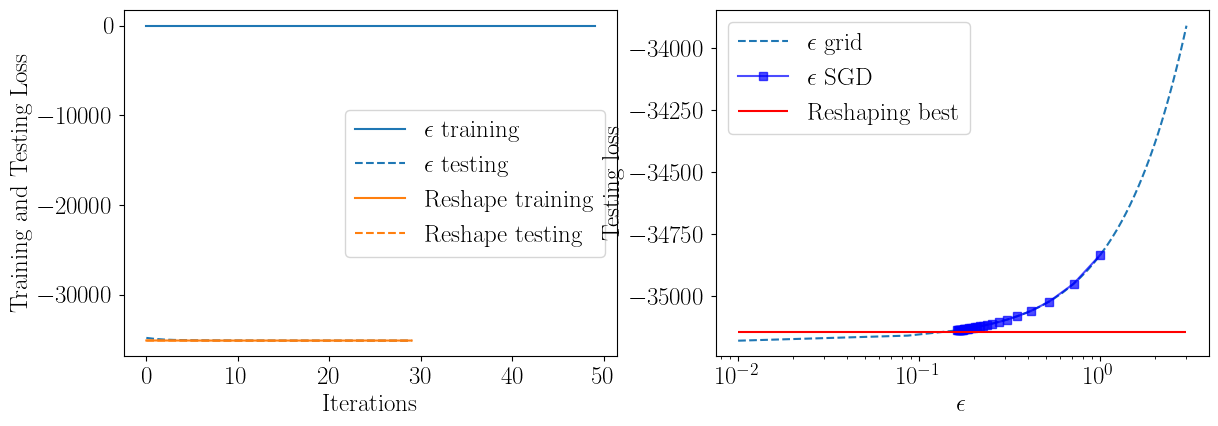

In [244]:

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5))
ax1.plot(df_eps['step'], df_eps['Loss_val'], color="tab:blue", label=r"$\epsilon$ training")
ax1.plot(df_r2['step'], df_r2['Eval_val'], linestyle='--', color="tab:blue", label=r"$\epsilon$ testing")
ax1.plot(df_r1['step'], df_r1['Loss_val'], color="tab:orange", label="Reshape training")
ax1.plot(df_r1['step'], df_r1['Eval_val'], linestyle='--', color="tab:orange", label="Reshape testing")
ax1.legend()
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Training and Testing Loss")

styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
ax2.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
ax2.plot(df_r2["A_norm"],df_r2["Eval_val"], linestyle='-', marker=styles[j], color = "blue", label="$\epsilon$ SGD",alpha = 0.7)
ax2.hlines( xmin = np.min(dfgrid["Eps"]), xmax = np.max(dfgrid["Eps"]), y = np.min(df_r1["Eval_val"]), label = "Reshaping best", color= "red")   
ax2.set_xlabel("$\epsilon$")
ax2.set_ylabel("Testing loss")
ax2.set_xscale("log")
ax2.legend()
plt.show()


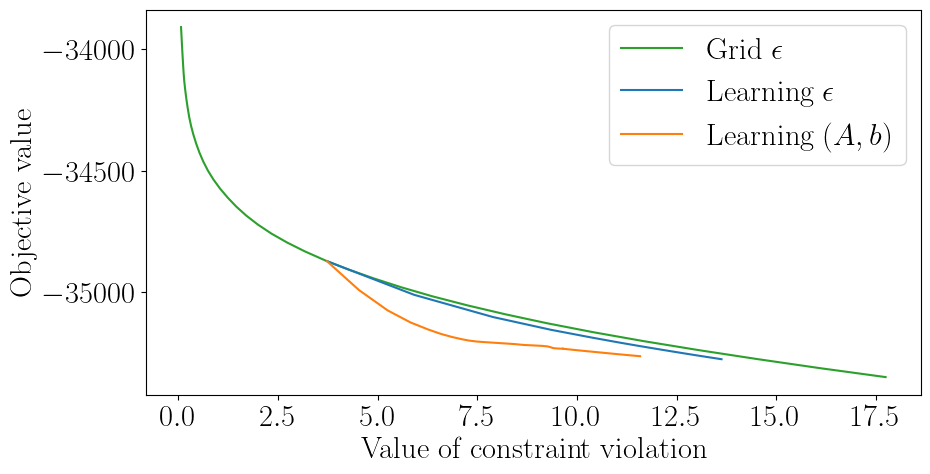

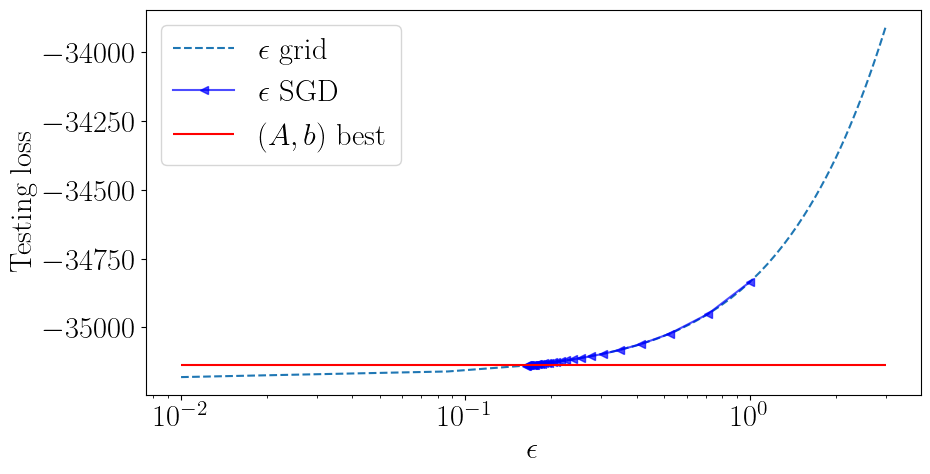

In [245]:
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":22,
    "font.family": "serif"
})
new = pareto_frontier(df_r1['Violations'],df_r1['Test_val'])
new1 = pareto_frontier(df1['Violations'],df1['Test_val'])
plt.figure(figsize=(10,5))
plt.plot(dfgrid['Violations'], dfgrid['Test_val'], color="tab:green", label=r"Grid $\epsilon$")
plt.plot(df_r2['Violations'], df_r2['Test_val'], color="tab:blue", label=r"Learning $\epsilon$")

# plt.plot(df_r1['Violations'], df_r1['Opt_val'], color="tab:orange" )
plt.plot(new[0], new[1], color="tab:orange", label=r"Learning $(A,b)$")
plt.plot(new1[0], new1[1], color="tab:orange")
plt.ylabel("Objective value")
# ax2.set_xlim([-1,20])
plt.xlabel("Value of constraint violation")
plt.legend(loc = "upper right")
# plt.savefig("Inventory.pdf",bbox_inches='tight')
plt.show()
plt.figure(figsize=(10, 5))

styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
plt.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
plt.plot(df_r2["A_norm"],df_r2["Eval_val"], linestyle='-', marker="<", color = "blue", label="$\epsilon$ SGD",alpha = 0.7)
plt.hlines( xmin = np.min(dfgrid["Eps"]), xmax = np.max(dfgrid["Eps"]), y = np.min(df1["Eval_val"]), label = "$(A,b)$ best", color= "red")  
plt.xscale("log") 
plt.xlabel("$\epsilon$")
plt.ylabel("Testing loss")
plt.legend()
# plt.savefig("Inventory_train.pdf",bbox_inches='tight')


In [248]:

n = 10
m = 4
# data = np.random.normal(0,3,(400,m))
# data = data_modes(N,m,[10,20,30])
#restate the ellipsoidal set
# u = lro.UncertainParameter(m,
#                                 uncertainty_set = lro.Ellipsoidal(p=2, 
#                                                                   rho=1., data =data, loss =loss))
K = 5
u = lro.UncertainParameter(m,
                                uncertainty_set = lro.MRO(p=2, K = K,
                                                                  rho=1., data =data, loss =loss, uniqueA = True))
Astart = u.uncertainty_set._initA
# formulate cvxpy variable
L = cp.Variable()
s = cp.Variable(n)
y = cp.Variable(n)
Y = cp.Variable((n,m))

# formulate problem constants
# C = 2000
# c = np.random.uniform(300,500,n)
# Q = np.random.uniform(-2,2,(n,m))
# d = np.random.uniform(100,200,n)
# t = np.random.uniform(1,3,n)
# h = np.random.uniform(1,3,n)
# r = np.random.uniform(20,40,n)


# formulate objective
objective = cp.Minimize(L)

# formulate constraints
constraints = [-r@y - r@Y@u + (t+h)@s <= L]
for i in range(n):
    constraints += [y[i]+Y[i]@u <= s[i]]
    constraints += [y[i]<= d[i]+ (Q[i] - Y[i])@u]
constraints += [np.ones(n)@s == C]
constraints += [s <=c, s >=0]

# formulate Robust Problem
prob = lro.RobustProblem(objective, constraints)

# solve
s = 1
# Train only epsilon
# result = prob.train(eps = True, lr = 0.001, step=30, momentum = 0.8, optimizer = "SGD", initeps = 2, seed = s)
# df_eps = result.df
# Train A and b
result1 = prob.train(lr = 0.0001, step=50, momentum = 0.8, optimizer = "SGD", seed = s, fixb = False)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

result2 = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initA = A_fin, initb = b_fin)
df_r1 = result2.df

init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(data.T)))
init_b = -init@np.mean(data, axis=0)
result3 = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initA = None, initb = init_b )
df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.01, 3, 40), initA = None, initb = init_b, seed = s)
 
dfgrid = result4.df

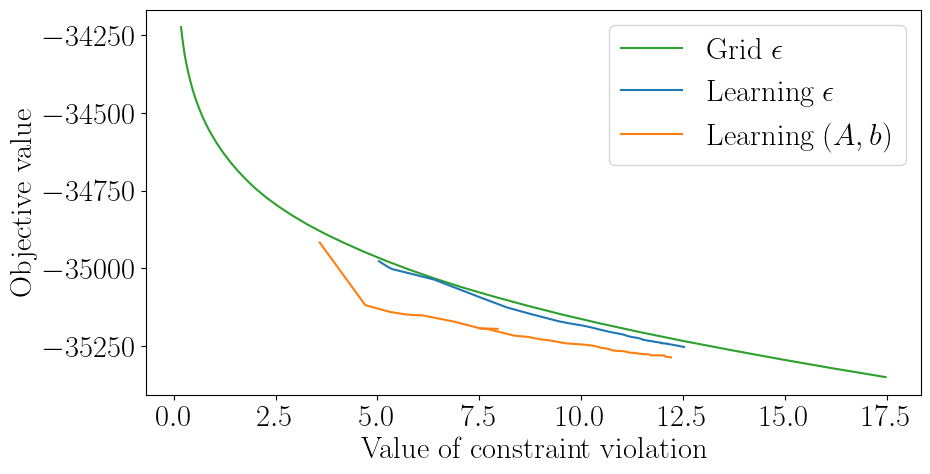

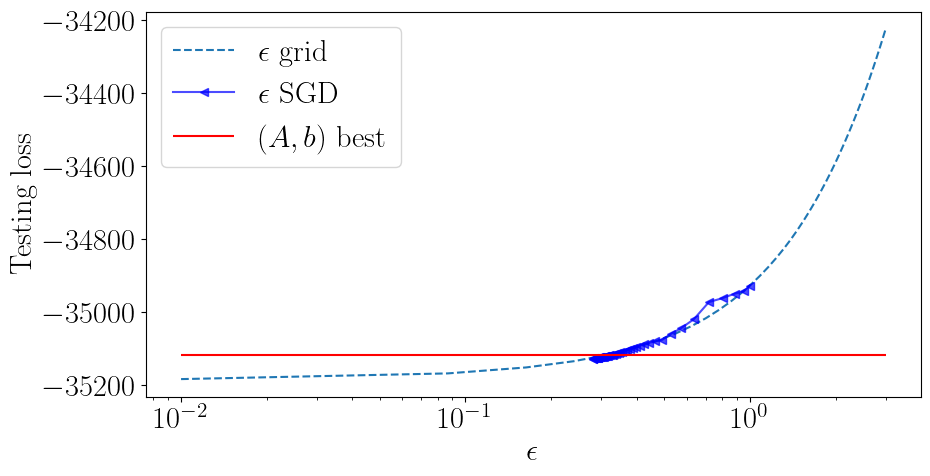

In [249]:
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":22,
    "font.family": "serif"
})
new = pareto_frontier(df_r1['Violations'],df_r1['Test_val'])
new1 = pareto_frontier(df1['Violations'],df1['Test_val'])
plt.figure(figsize=(10,5))
plt.plot(dfgrid['Violations'], dfgrid['Test_val'], color="tab:green", label=r"Grid $\epsilon$")
plt.plot(df_r2['Violations'], df_r2['Test_val'], color="tab:blue", label=r"Learning $\epsilon$")

# plt.plot(df_r1['Violations'], df_r1['Opt_val'], color="tab:orange" )
plt.plot(new[0], new[1], color="tab:orange")
plt.plot(new1[0], new1[1], color="tab:orange", label=r"Learning $(A,b)$")
plt.ylabel("Objective value")
# ax2.set_xlim([-1,20])
plt.xlabel("Value of constraint violation")
plt.legend(loc = "upper right")
# plt.savefig("Inventory.pdf",bbox_inches='tight')
plt.show()
plt.figure(figsize=(10, 5))

styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
plt.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
plt.plot(df_r2["A_norm"],df_r2["Eval_val"], linestyle='-', marker="<", color = "blue", label="$\epsilon$ SGD",alpha = 0.7)
plt.hlines( xmin = np.min(dfgrid["Eps"]), xmax = np.max(dfgrid["Eps"]), y = np.min(df1["Eval_val"]), label = "$(A,b)$ best", color= "red")  
plt.xscale("log") 
plt.xlabel("$\epsilon$")
plt.ylabel("Testing loss")
plt.legend()
# plt.savefig("Inventory_train.pdf",bbox_inches='tight')


In [250]:

n = 10
m = 4
# data = np.random.normal(0,3,(400,m))
# data = data_modes(N,m,[10,20,30])
#restate the ellipsoidal set
u = lro.UncertainParameter(m,
                                uncertainty_set = lro.Ellipsoidal(p=2, 
                                                                  rho=1., data =data, loss =loss))

# formulate cvxpy variable
L = cp.Variable()
s = cp.Variable(n)
y = cp.Variable(n)
Y = cp.Variable((n,m))

# formulate objective
objective = cp.Minimize(L)

# formulate constraints
constraints = [-r@y - r@Y@u + (t+h)@s <= L]
for i in range(n):
    constraints += [y[i]+Y[i]@u <= s[i]]
    constraints += [y[i]<= d[i]+ (Q[i] - Y[i])@u]
constraints += [np.ones(n)@s == C]
constraints += [s <=c, s >=0]

# formulate Robust Problem
prob = lro.RobustProblem(objective, constraints)

# solve
s = 1
# Train only epsilon
# result = prob.train(eps = True, lr = 0.001, step=30, momentum = 0.8, optimizer = "SGD", initeps = 2, seed = s)
# df_eps = result.df
# Train A and b
result1 = prob.train(lr = 0.0001, step=30, momentum = 0.8, optimizer = "SGD", seed = s, fixb = False)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

result2 = prob.train(eps = True, lr = 0.001, step=30, momentum = 0.8, optimizer = "SGD", seed = s, initA = A_fin, initb = b_fin)
df_r1 = result2.df

init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(data.T)))
init_b = -init@np.mean(data, axis=0)
result3 = prob.train(eps = True, lr = 0.001, step=30, momentum = 0.8, optimizer = "SGD", seed = s, initA = init, initb = init_b )
df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.01, 3, 40), initA = init, initb = init_b, seed = s)
 
dfgrid = result4.df

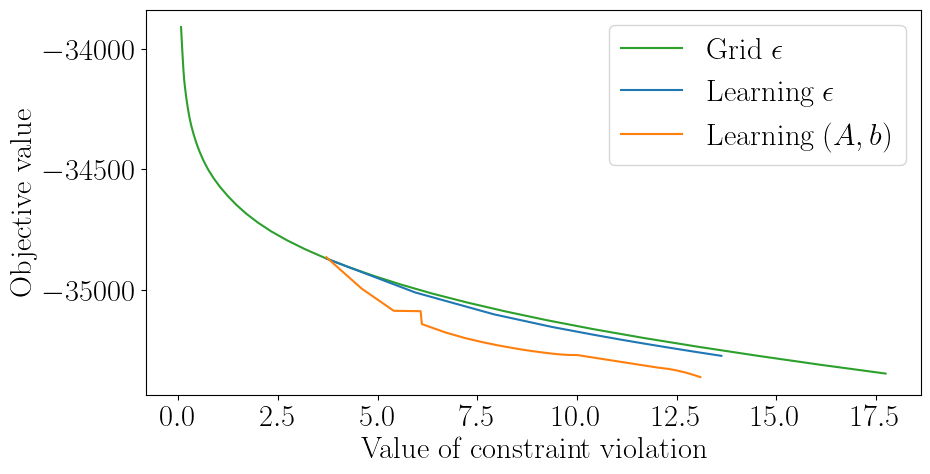

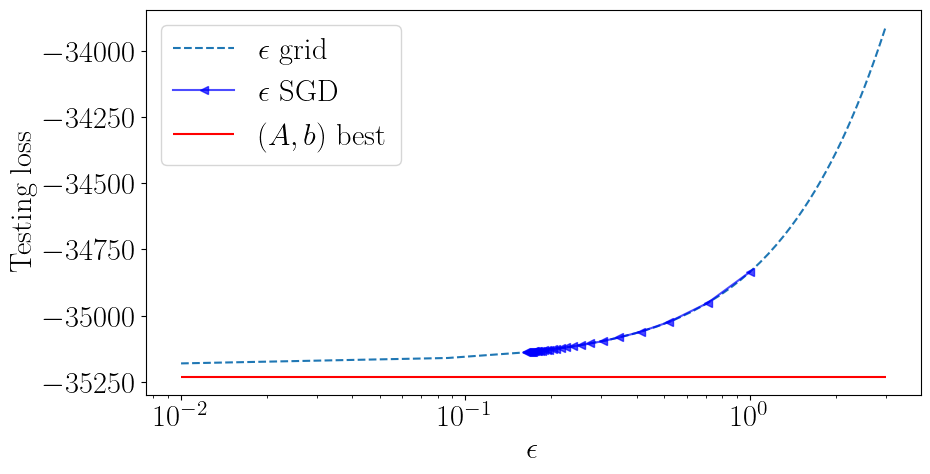

In [251]:
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":22,
    "font.family": "serif"
})
# new = pareto_frontier(df_r1['Violations'],df_r1['Test_val'])
new1 = pareto_frontier(df1['Violations'],df1['Test_val'])
plt.figure(figsize=(10,5))
plt.plot(dfgrid['Violations'], dfgrid['Test_val'], color="tab:green", label=r"Grid $\epsilon$")
plt.plot(df_r2['Violations'], df_r2['Test_val'], color="tab:blue", label=r"Learning $\epsilon$")

# plt.plot(df_r1['Violations'], df_r1['Opt_val'], color="tab:orange" )
# plt.plot(new[0], new[1], color="tab:orange")
plt.plot(new1[0], new1[1], color="tab:orange", label=r"Learning $(A,b)$")
plt.ylabel("Objective value")
# ax2.set_xlim([-1,20])
plt.xlabel("Value of constraint violation")
plt.legend(loc = "upper right")
# plt.savefig("Inventory.pdf",bbox_inches='tight')
plt.show()
plt.figure(figsize=(10, 5))

styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
plt.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
plt.plot(df_r2["A_norm"],df_r2["Eval_val"], linestyle='-', marker="<", color = "blue", label="$\epsilon$ SGD",alpha = 0.7)
plt.hlines( xmin = np.min(dfgrid["Eps"]), xmax = np.max(dfgrid["Eps"]), y = np.min(df1["Eval_val"]), label = "$(A,b)$ best", color= "red")  
plt.xscale("log") 
plt.xlabel("$\epsilon$")
plt.ylabel("Testing loss")
plt.legend()
# plt.savefig("Inventory_train.pdf",bbox_inches='tight')


### Example 4: Affine Adjustable Robust Optimization: Hydro power plant


In [313]:
def loss(tau, x0, x1, x2, x3, x4, x5, data,l=5):
    sums = 0
    x = {}
    x[0] = x1
    x[1] = x2 
    x[2] = x3 
    x[3] = x4
    x[4] = x5
    Nsample = data.shape[0]
    for ind in range(Nsample):
        for t in range(T):
            sums += torch.maximum(-x0[t] - x[t]@torch.tensor(P[t])@data[ind], torch.tensor(0.,requires_grad = True))
            sums += torch.maximum(torch.tensor(l0) - torch.tensor(lhigh) + torch.tensor(np.ones(t+1)@P[t])@data[i] - torch.sum(torch.stack([x0[i] + x[i]@torch.tensor(P[i])@data[ind] for i in range(t+1)])), torch.tensor(0.,requires_grad = True))
            sums += torch.maximum(torch.tensor(llow) - torch.tensor(l0) - torch.tensor(np.ones(t+1)@P[t])@data[ind] + torch.sum(torch.stack([x0[i] + x[i]@torch.tensor(P[i])@data[ind] for i in range(t+1)])), torch.tensor(0.,requires_grad = True))
    return tau + torch.tensor(l)*sums/Nsample, tau, sums/Nsample


In [315]:

import math
T = 5
data = np.random.normal(1,0.1,(100,T))
# data = data_modes(N,m,[10,20,30])
#restate the ellipsoidal set
u = lro.UncertainParameter(T,
                                uncertainty_set = lro.Ellipsoidal(p=2, 
                                                                  rho=1, data =data, loss =loss))
# K = 1
# u = lro.UncertainParameter(T,
#                                 uncertainty_set = lro.MRO(p=2, K = K, 
#                                                                   rho=1, data =data, loss =loss, uniqueA = True))
# formulate cvxpy variable
tau = cp.Variable()
x0 = cp.Variable(T)
x = {}
for t in range(T):
    x[t] = cp.Variable(t+1)

# formulate problem constants
P = {}
for t in range(T):
    P[t] = np.eye(T)[0:t+1,:]
l0 = 1
lhigh = 5
llow = 1
c = np.zeros(T)
for i in range(T):
    c[i] = 10 + 5*math.sin(math.pi*(1-(i+1))/3)


# formulate objective
objective = cp.Minimize(tau)

# formulate constraints
constraints = [-cp.sum([c[t]*x0[t] + c[t]*x[t]@P[t]@u for t in range(T)]) <= tau]
constraints += [cp.maximum(*[l0 - lhigh + np.ones(t+1)@P[t]@u - cp.sum([x0[i] + x[i]@P[i]@u for i in range(t+1)]) for t in range(T)], *[llow - l0 - np.ones(t+1)@P[t]@u  + cp.sum([x0[i] + x[i]@P[i]@u for i in range(t+1)]) for t in range(T)]) <= 0]
for t in range(T):
    constraints += [-x0[t] - x[t]@P[t]@u <= 0]

# formulate Robust Problem
prob = lro.RobustProblem(objective, constraints)

# solve
s = 1
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(data.T)))
init_b = -init@np.mean(data, axis=0)
# Train only epsilon
# result = prob.train(eps = True, lr = 0.001, step=30, momentum = 0.8, optimizer = "SGD", initeps = 0.001, seed = s)
# df_eps  = result.df
# Train A and b
result1 = prob.train(lr = 0.001, step=40, momentum = 0.8, optimizer = "SGD", initA = init, initb = init_b, seed = s, fixb = False)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

result2 = prob.train(eps = True, lr = 0.001, step=40, momentum = 0.8, optimizer = "SGD", seed = s, initA = A_fin, initb = b_fin)
df_r1 = result2.df

result3 = prob.train(eps = True, lr = 0.001, step=40, momentum = 0.8, optimizer = "SGD", seed = s, initA = init, initb = init_b, initeps = 0.001)
df_r2 = result3.df
# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.0001, 0.01, 40), initA = init, initb = init_b, seed = s)
dfgrid = result4.df
result5 = prob.grid(epslst = np.linspace(0.0001, 0.01, 40), initA = A_fin, initb = b_fin, seed = s)
dfgrid2 = result5.df


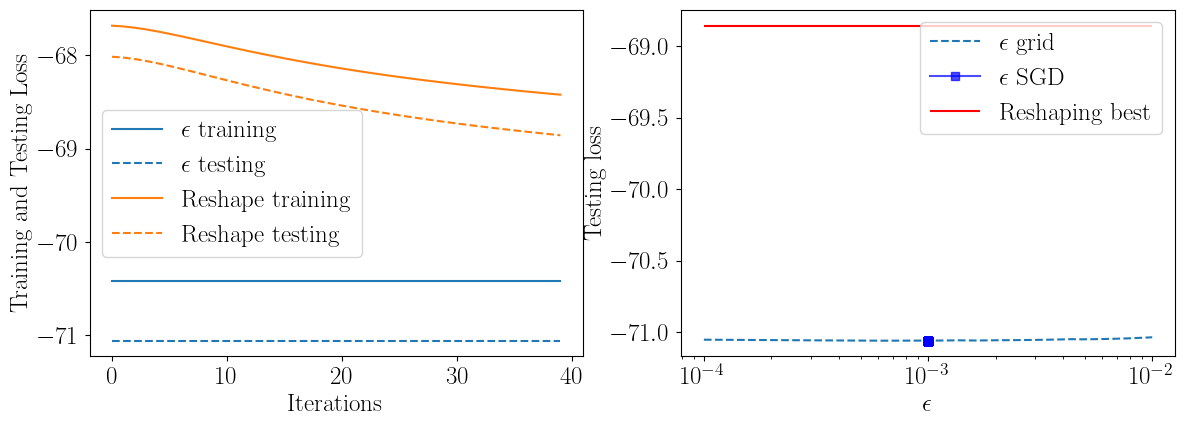

In [316]:

# Plot results
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5))
ax1.plot(df_r2['step'], df_r2['Loss_val'], color="tab:blue", label=r"$\epsilon$ training")
ax1.plot(df_r2['step'], df_r2['Eval_val'], linestyle='--', color="tab:blue", label=r"$\epsilon$ testing")
ax1.plot(df_r1['step'], df_r1['Loss_val'], color="tab:orange", label="Reshape training")
ax1.plot(df_r1['step'], df_r1['Eval_val'], linestyle='--', color="tab:orange", label="Reshape testing")
ax1.legend()
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Training and Testing Loss")

styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
ax2.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
ax2.plot(df_r2["A_norm"],df_r2["Eval_val"], linestyle='-', marker=styles[j], color = "blue", label="$\epsilon$ SGD",alpha = 0.7)
ax2.hlines( xmin = np.min(dfgrid["Eps"]), xmax = np.max(dfgrid["Eps"]), y = np.min(df_r1["Eval_val"]), label = "Reshaping best", color= "red")   
ax2.set_xlabel("$\epsilon$")
ax2.set_ylabel("Testing loss")
ax2.set_xscale("log")
ax2.legend()
plt.show()


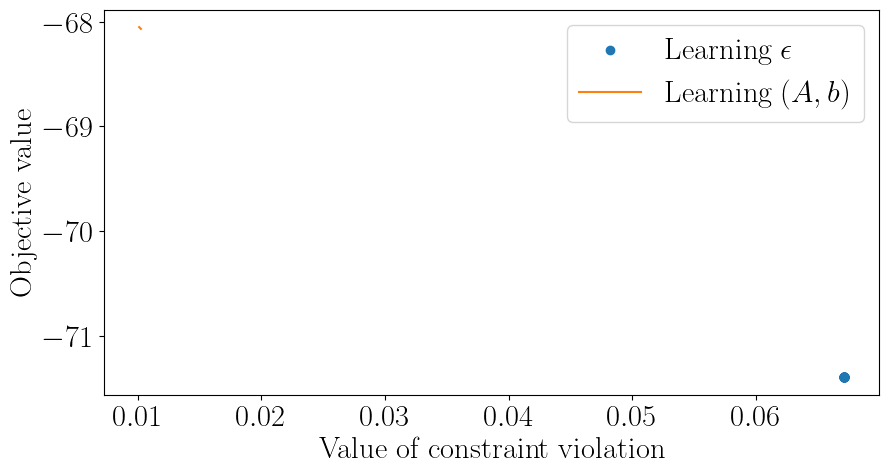

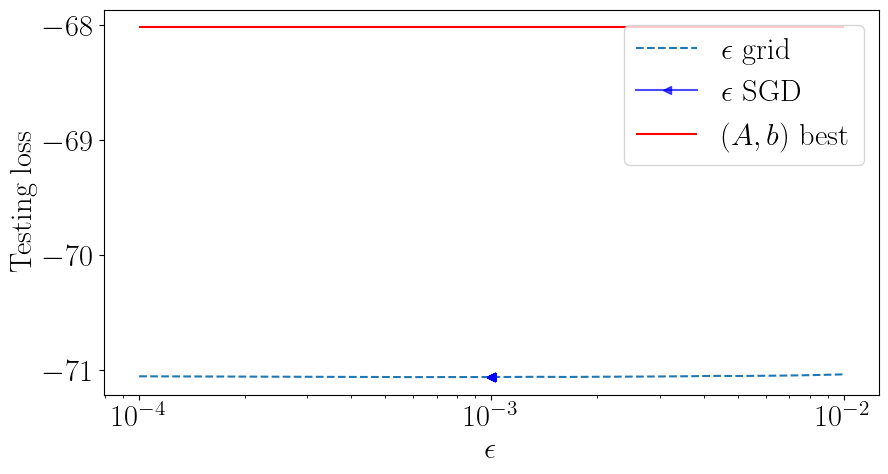

In [317]:
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":22,
    "font.family": "serif"
})
plt.figure(figsize=(10,5))
plt.scatter(df_r2['Violations'], df_r2['Opt_val'], color="tab:blue", label=r"Learning $\epsilon$")
plt.plot(df1['Violations'], df1['Opt_val'], color="tab:orange", label=r"Learning $(A,b)$")
plt.ylabel("Objective value")
# ax2.set_xlim([-1,20])
plt.xlabel("Value of constraint violation")
plt.legend(loc = "upper right")
# plt.savefig("Hydro.pdf",bbox_inches='tight')
plt.show()
plt.figure(figsize=(10, 5))

styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
plt.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
plt.plot(df_r2["A_norm"],df_r2["Eval_val"], linestyle='-', marker="<", color = "blue", label="$\epsilon$ SGD",alpha = 0.7)
plt.hlines( xmin = np.min(dfgrid["Eps"]), xmax = np.max(dfgrid["Eps"]), y = np.min(df1["Eval_val"]), label = "$(A,b)$ best", color= "red")  
plt.xscale("log") 
plt.xlabel("$\epsilon$")
plt.ylabel("Testing loss")
plt.legend()
# plt.savefig("Hydro_train.pdf",bbox_inches='tight')
